In [1]:
import scipy.io as sio

# Load the pubmed dataset as an example
pubmed_data = sio.loadmat('Données_relationnelles/pubmed.mat')
print(pubmed_data.keys())  # This will show the keys: 'fea', 'W', 'gnd'

# Extract feature matrix (X), adjacency matrix (W), and labels (gnd)
X_pubmed = pubmed_data['fea']
W_pubmed = pubmed_data['W'] ## matrice d'ajacence
gnd_pubmed = pubmed_data['gnd'].flatten()  # Flatten to make it a 1D arrayc'est les labels


dict_keys(['__header__', '__version__', '__globals__', 'fea', 'W', 'gnd'])


In [2]:
pubmed_data

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Wed Jan 30 19:12:21 2019',
 '__version__': '1.0',
 '__globals__': [],
 'fea': array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.10463634, 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.01942665, 0.0079607 , ..., 0.        , 0.        ,
         0.        ],
        [0.10782092, 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.02658384, 0.        , ..., 0.        , 0.        ,
         0.        ]]),
 'W': <19717x19717 sparse matrix of type '<class 'numpy.float64'>'
 	with 88651 stored elements in Compressed Sparse Column format>,
 'gnd': array([[2],
        [2],
        [1],
        ...,
        [3],
        [1],
        [3]], dtype=uint8)}

In [34]:
import numpy as np

# Shapes of matrices
print(f"Shape of feature matrix X: {X_pubmed.shape}")
print(f"Shape of adjacency matrix W: {W_pubmed.shape}")
print(f"Shape of labels gnd: {gnd_pubmed.shape}")

# Basic statistics about the labels
unique_labels, label_counts = np.unique(gnd_pubmed, return_counts=True)
print(f"Unique labels: {unique_labels}")
print(f"Label counts: {label_counts}")


Shape of feature matrix X: (19717, 500)
Shape of adjacency matrix W: (19717, 19717)
Shape of labels gnd: (19717,)
Unique labels: [1 2 3]
Label counts: [4103 7739 7875]


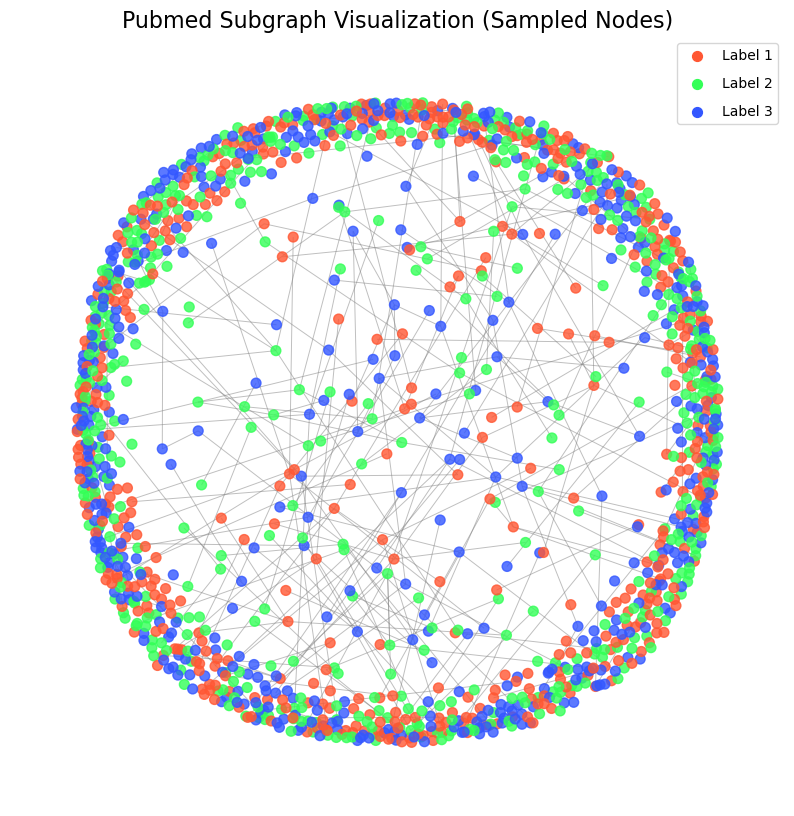

In [35]:
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib.colors import ListedColormap
import numpy as np

# Step 1: Convert adjacency matrix to a graph
graph = nx.from_scipy_sparse_array(W_pubmed)

# Step 2: Sample nodes to create a smaller subgraph
labels = gnd_pubmed  # Labels (1, 2, 3)
unique_labels = sorted(set(labels))  # Get unique labels

# Define the number of nodes to sample per label
nodes_per_label = 500
sampled_nodes = []

for label in unique_labels:
    # Find all nodes with the current label
    nodes_with_label = np.where(labels == label)[0]
    
    # Randomly sample nodes from this label
    sampled_nodes.extend(np.random.choice(nodes_with_label, size=nodes_per_label, replace=False))

# Create a subgraph with sampled nodes
subgraph = graph.subgraph(sampled_nodes)

# Step 3: Assign labels and map colors
color_map = ListedColormap(['#FF5733', '#33FF57', '#3357FF'])  # Colors for each label
node_colors = [color_map.colors[labels[node] - 1] for node in subgraph.nodes]

# Step 4: Compute a spring layout for the subgraph
layout = nx.spring_layout(subgraph, seed=42, k=0.3)

# Step 5: Visualize the subgraph
plt.figure(figsize=(10, 10))  # Adjust figure size

# Draw nodes and edges
nx.draw_networkx_nodes(subgraph, layout, node_size=50, node_color=node_colors, alpha=0.8)
nx.draw_networkx_edges(subgraph, layout, edge_color='gray', alpha=0.5, width=0.7)

# Add legend for node labels
for idx, label in enumerate(unique_labels):
    plt.scatter([], [], c=color_map.colors[idx], label=f"Label {label}", s=50)
plt.legend(scatterpoints=1, frameon=True, labelspacing=1, loc='upper right')

# Add title and show the graph
plt.title("Pubmed Subgraph Visualization (Sampled Nodes)", fontsize=16)
plt.axis("off")
plt.show()


In [36]:
import numpy as np

# Nombre total de connexions
total_connections = W_pubmed.nnz  # Nombre d'éléments non nuls dans la matrice

# Liste des lignes, colonnes et valeurs de la matrice d'adjacence
rows, cols = W_pubmed.nonzero()

# Compter les connexions internes et externes
internal_connections = 0
external_connections = 0

for i, j in zip(rows, cols):
    if gnd_pubmed[i] == gnd_pubmed[j]:
        internal_connections += 1
    else:
        external_connections += 1

# Calcul des proportions
prop_internal = internal_connections / total_connections
prop_external = external_connections / total_connections

print(f"Proportion des connexions internes (même catégorie) : {prop_internal:.2%}")
print(f"Proportion des connexions externes (différentes catégories) : {prop_external:.2%}")


Proportion des connexions internes (même catégorie) : 80.24%
Proportion des connexions externes (différentes catégories) : 19.76%


Interprétation :
Proportion élevée des connexions internes (80,24 %) :

Cela indique que les publications ont tendance à être "groupées" par catégorie. Par exemple, les publications sur un même sujet ou domaine (catégorie) citent principalement d'autres travaux similaires dans le même domaine.



Proportion modérée des connexions externes (19,76 %) :

Cela montre qu'il y a un certain degré d'interaction entre les catégories. Ces connexions peuvent représenter des publications qui se basent sur des idées ou des références provenant de différentes disciplines, ou des recherches multidisciplinaires.

##### EDA

Feature Matrix X_pubmed Shape: (19717, 500)
Adjacency Matrix W_pubmed Shape: (19717, 19717)
Labels Shape: (19717,)
Unique Labels: [1 2 3]
Label Counts: [4103 7739 7875]


C:\Users\Rania\AppData\Local\Temp\ipykernel_21916\274803404.py:19: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




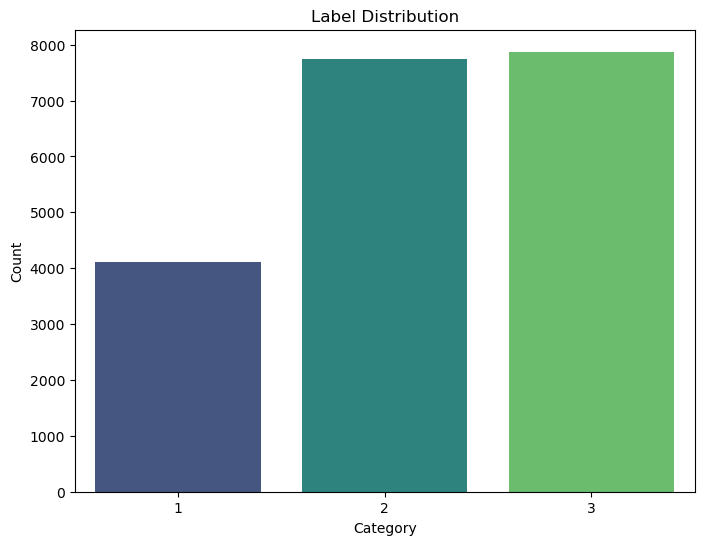

In [37]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from collections import Counter
import networkx as nx

# Step 1: Dataset Overview
print("Feature Matrix X_pubmed Shape:", X_pubmed.shape)
print("Adjacency Matrix W_pubmed Shape:", W_pubmed.shape)
print("Labels Shape:", gnd_pubmed.shape)

unique_labels, label_counts = np.unique(gnd_pubmed, return_counts=True)
print("Unique Labels:", unique_labels)
print("Label Counts:", label_counts)

# Plot Label Distribution
plt.figure(figsize=(8, 6))
sns.barplot(x=unique_labels, y=label_counts, palette="viridis")
plt.title("Label Distribution")
plt.xlabel("Category")
plt.ylabel("Count")
plt.show()




On a un desequillibre de classes

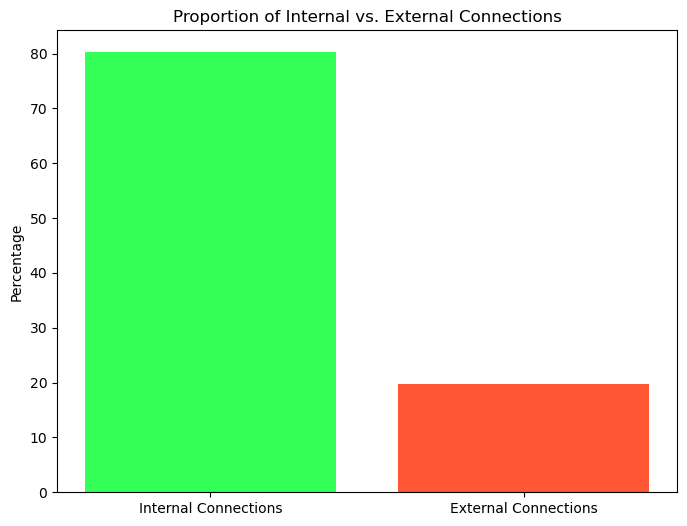

Proportion of Internal Connections: 80.24%
Proportion of External Connections: 19.76%


In [38]:
# Step 2: Proportion of Internal vs. External Connections
internal_connections = 0
external_connections = 0

for node in range(W_pubmed.shape[0]):
    for neighbor in W_pubmed[node].nonzero()[1]:
        if gnd_pubmed[node] == gnd_pubmed[neighbor]:
            internal_connections += 1
        else:
            external_connections += 1

total_connections = internal_connections + external_connections
internal_prop = internal_connections / total_connections * 100
external_prop = external_connections / total_connections * 100

# Plot Proportions
plt.figure(figsize=(8, 6))
plt.bar(["Internal Connections", "External Connections"], [internal_prop, external_prop], color=["#33FF57", "#FF5733"])
plt.title("Proportion of Internal vs. External Connections")
plt.ylabel("Percentage")
plt.show()

print(f"Proportion of Internal Connections: {internal_prop:.2f}%")
print(f"Proportion of External Connections: {external_prop:.2f}%")



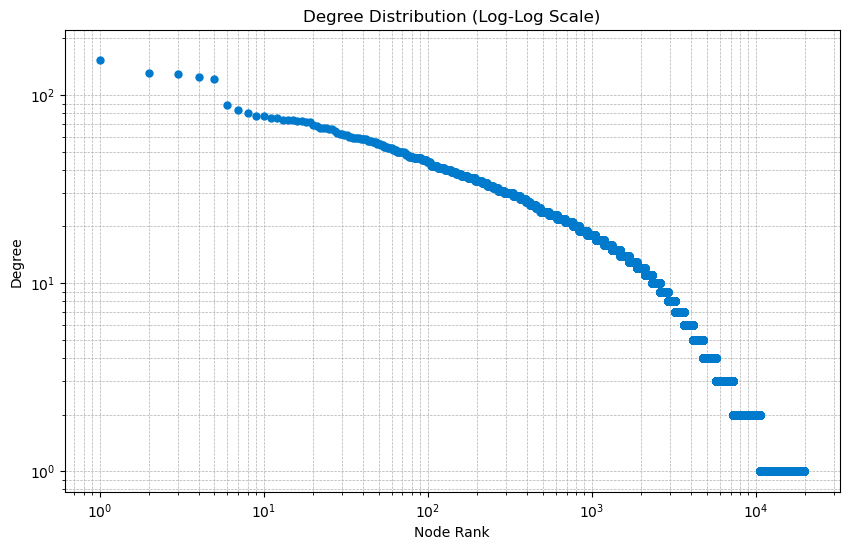

In [39]:
# Step 3: Degree Distribution
graph = nx.from_scipy_sparse_array(W_pubmed)
degree_sequence = sorted([d for n, d in graph.degree()], reverse=True)

plt.figure(figsize=(10, 6))
plt.loglog(degree_sequence, marker="o", color="#007acc", markersize=5, linestyle="None")
plt.title("Degree Distribution (Log-Log Scale)")
plt.xlabel("Node Rank")
plt.ylabel("Degree")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()



La distribution est quasi normale

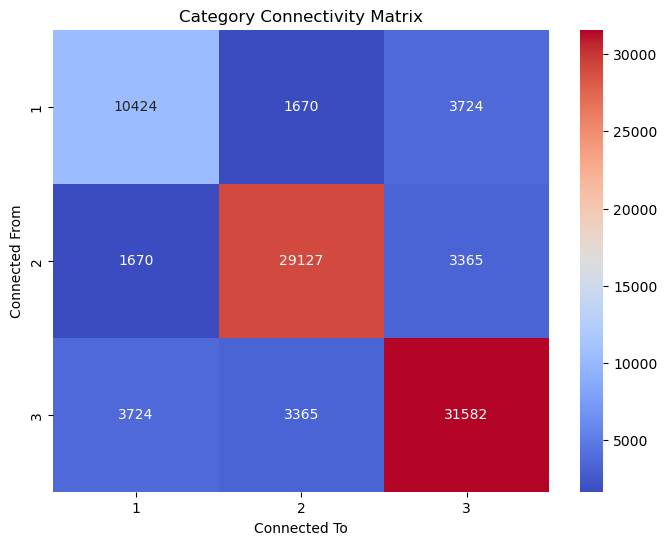

In [40]:
# Step 4: Category Connectivity Matrix
connectivity_matrix = np.zeros((len(unique_labels), len(unique_labels)))

for node in range(W_pubmed.shape[0]):
    for neighbor in W_pubmed[node].nonzero()[1]:
        connectivity_matrix[gnd_pubmed[node] - 1, gnd_pubmed[neighbor] - 1] += 1

plt.figure(figsize=(8, 6))
sns.heatmap(connectivity_matrix, annot=True, fmt=".0f", cmap="coolwarm", xticklabels=unique_labels, yticklabels=unique_labels)
plt.title("Category Connectivity Matrix")
plt.xlabel("Connected To")
plt.ylabel("Connected From")
plt.show()



In [41]:
import plotly.express as px
import pandas as pd
from sklearn.decomposition import PCA

# Step 6: Feature Space Exploration (PCA in 3D)
pca = PCA(n_components=3)
X_pca_3d = pca.fit_transform(X_pubmed)


# Convert to DataFrame for easier handling in Plotly
pca_df = pd.DataFrame(X_pca_3d, columns=['Principal Component 1', 'Principal Component 2', 'Principal Component 3'])
pca_df['Label'] = gnd_pubmed

# Create an interactive 3D scatter plot
fig = px.scatter_3d(
    pca_df,
    x='Principal Component 1',
    y='Principal Component 2',
    z='Principal Component 3',
    color=pca_df['Label'].astype(str),  # Color points by label
    title="Feature Space Visualization (PCA in 3D)",
    labels={'color': 'Label'},  # Legend label
    opacity=0.7
)

# Update layout for better visualization
fig.update_layout(
    scene=dict(
        xaxis_title="Principal Component 1",
        yaxis_title="Principal Component 2",
        zaxis_title="Principal Component 3"
    ),
    legend=dict(title="Labels", itemsizing='constant')
)

# Show the interactive plot
fig.show()


On ne peut pas voir une claire separation entre les categories

 Les données relationnelles représentent deux types d’information, une matrice des
 valeurs objets/caractéristiques et un graphe des liens entre objets, qui fournissent
 des informations utiles sous différents angles, mais ils ne sont pas toujours
 cohérents et doivent donc être soigneusement alignés pour obtenir les meilleurs
 résultats de classification. L’objectif de cette partie du projet est d'aborder ce
 problème, afin de mettre en lumières les différents challenges posés par ce type de
 données aux méthodes de  classification.

## Approches de combinaison des features x-pubmed et les lien w-pubmed

In [ ]:
from sklearn.model_selection import train_test_split

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X_pubmed,           # Feature matrix
    gnd_pubmed,         # Labels
    test_size=0.3,      # 30% for testing, 70% for training
    random_state=42,    # Ensures reproducibility
    stratify=gnd_pubmed # Preserves the distribution of labels across splits
)

# Print the shapes to verify
print(f"Training set shape: X_train={X_train.shape}, y_train={y_train.shape}")
print(f"Testing set shape: X_test={X_test.shape}, y_test={y_test.shape}")


Training set shape: X_train=(13801, 500), y_train=(13801,)
Testing set shape: X_test=(5916, 500), y_test=(5916,)


### Aproche 1 : 
 1. Uniquement l’information contenue dans la matrice X


#### Logistic Regression

In [43]:
import evaluation
from supervised import logistic_regression_model

# Step 1: Define the model name and function
model_name = "Logistic Regression"
model_func = logistic_regression_model

# Step 2: Evaluate the model with sampling
results, best_method = evaluation.evaluate_model_with_sampling(
    model_func, model_name, X_train, y_train, encode=False
)
print(f"Best Sampling Method: {best_method}")
print(f"Results: {results}")





Evaluating Logistic Regression...
Applying SMOTE for oversampling...
Équilibrage effectué avec SMOTE (oversampling).
Running Logistic Regression grid search...
Best Params: {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}
Logistic Regression (Oversampling): Best Params: {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}
Accuracy for Logistic Regression (Oversampling): 0.3994
Applying NearMiss for undersampling...
Équilibrage effectué avec NearMiss (undersampling).
Running Logistic Regression grid search...


c:\Users\Rania\anaconda3\envs\basee\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Best Params: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
Logistic Regression (Undersampling): Best Params: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
Accuracy for Logistic Regression (Undersampling): 0.8697
Applying SMOTETomek for combination...
Équilibrage effectué avec SMOTETomek (combination).
Running Logistic Regression grid search...
Best Params: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
Logistic Regression (Combination): Best Params: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
Accuracy for Logistic Regression (Combination): 0.8922

Best Sampling Method for Logistic Regression: Combination with Accuracy: 0.8922
Best Sampling Method: Combination
Results: {'Oversampling': {'Best Params': {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}, 'Accuracy': 0.39939134845301066}, 'Undersampling': {'Best Params': {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}, 'Accuracy': 0.8697195855372799}, 'Combination': {'Best Params': {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}, 'Accuracy': 0.8

c:\Users\Rania\anaconda3\envs\basee\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression




Training the best model (Combination) with parameters: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
Data is a numpy array. Skipping categorical encoding.
Running Logistic Regression grid search...


c:\Users\Rania\anaconda3\envs\basee\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Best Params: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}


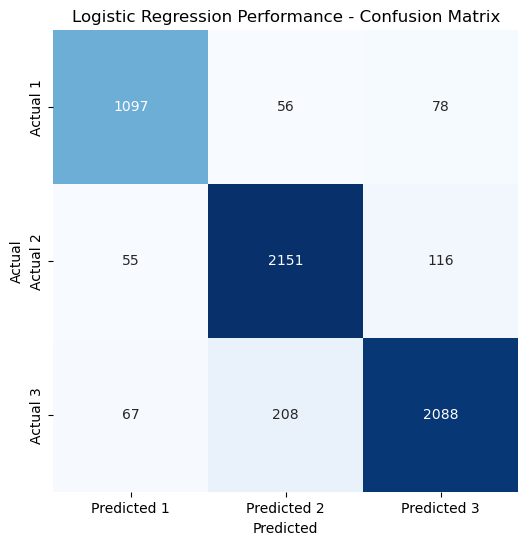


Logistic Regression Performance - Classification Report

              precision    recall  f1-score   support

           1       0.90      0.89      0.90      1231
           2       0.89      0.93      0.91      2322
           3       0.91      0.88      0.90      2363

    accuracy                           0.90      5916
   macro avg       0.90      0.90      0.90      5916
weighted avg       0.90      0.90      0.90      5916



In [44]:
# Step 3: Perform a full analysis with visualizations
from evaluation import full_analysis_with_visuals

# Logistic Regression does not need an encoder as encode=False
encoder = None

full_analysis_with_visuals(
    model_name=model_name,
    model_func=model_func,
    results=results,
    best_method=best_method,
    X_test=X_test,
    y_test=y_test,
    encoder=encoder,
    title=f"{model_name} Performance",
    binary=False  # Set to True if binary classification
)

#### Decision Treea

In [45]:
import evaluation
from supervised import *


import evaluation

model_name = "Decision Tree"
model_func = decision_tree_model  # Replace with any model function
results, best_method = evaluation.evaluate_model_with_sampling(model_func, model_name, X_train, y_train, encode= False)
print(f"Best Sampling Method: {best_method}")
print(f"Results: {results}")




Evaluating Decision Tree...
Applying SMOTE for oversampling...
Équilibrage effectué avec SMOTE (oversampling).
Running Decision Tree grid search...
Decision Tree (Oversampling): Best Params: {'max_depth': 20, 'min_samples_split': 2}
Accuracy for Decision Tree (Oversampling): 0.2081
Applying NearMiss for undersampling...
Équilibrage effectué avec NearMiss (undersampling).
Running Decision Tree grid search...
Decision Tree (Undersampling): Best Params: {'max_depth': 10, 'min_samples_split': 2}
Accuracy for Decision Tree (Undersampling): 0.8608
Applying SMOTETomek for combination...
Équilibrage effectué avec SMOTETomek (combination).
Running Decision Tree grid search...
Decision Tree (Combination): Best Params: {'max_depth': 20, 'min_samples_split': 2}
Accuracy for Decision Tree (Combination): 0.9659

Best Sampling Method for Decision Tree: Combination with Accuracy: 0.9659
Best Sampling Method: Combination
Results: {'Oversampling': {'Best Params': {'max_depth': 20, 'min_samples_split': 


Training the best model (Combination) with parameters: {'max_depth': 20, 'min_samples_split': 2}
Data is a numpy array. Skipping categorical encoding.
Running Decision Tree grid search...


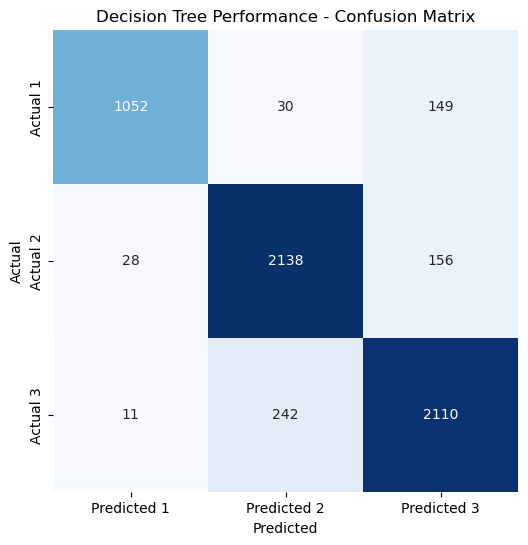


Decision Tree Performance - Classification Report

              precision    recall  f1-score   support

           1       0.96      0.85      0.91      1231
           2       0.89      0.92      0.90      2322
           3       0.87      0.89      0.88      2363

    accuracy                           0.90      5916
   macro avg       0.91      0.89      0.90      5916
weighted avg       0.90      0.90      0.90      5916



In [46]:
from evaluation import full_analysis_with_visuals

# Assuming an encoder was trained during preprocessing (if necessary)
encoder = None

full_analysis_with_visuals(
    model_name=model_name,
    model_func=model_func,
    results=results,
    best_method=best_method,
    X_test=X_test,
    y_test=y_test,
    encoder=encoder,
    title=f"{model_name} Performance",
    binary=False  # Set to True if binary classification
)


#### Random forest

In [47]:
import evaluation
from supervised import random_forest_model

model_name = "Random Forest"
model_func = random_forest_model

results, best_method = evaluation.evaluate_model_with_sampling(
    model_func, model_name, X_train, y_train, encode=False
)
print(f"Best Sampling Method: {best_method}")
print(f"Results: {results}")





Evaluating Random Forest...
Applying SMOTE for oversampling...
Équilibrage effectué avec SMOTE (oversampling).
Running Random Forest grid search...
Random Forest (Oversampling): Best Params: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}
Accuracy for Random Forest (Oversampling): 0.2081
Applying NearMiss for undersampling...
Équilibrage effectué avec NearMiss (undersampling).
Running Random Forest grid search...
Random Forest (Undersampling): Best Params: {'max_depth': None, 'min_samples_split': 10, 'n_estimators': 200}
Accuracy for Random Forest (Undersampling): 0.9315
Applying SMOTETomek for combination...
Équilibrage effectué avec SMOTETomek (combination).
Running Random Forest grid search...
Random Forest (Combination): Best Params: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Accuracy for Random Forest (Combination): 0.9952

Best Sampling Method for Random Forest: Combination with Accuracy: 0.9952
Best Sampling Method: Combination
Results: {'


Training the best model (Combination) with parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Data is a numpy array. Skipping categorical encoding.
Running Random Forest grid search...


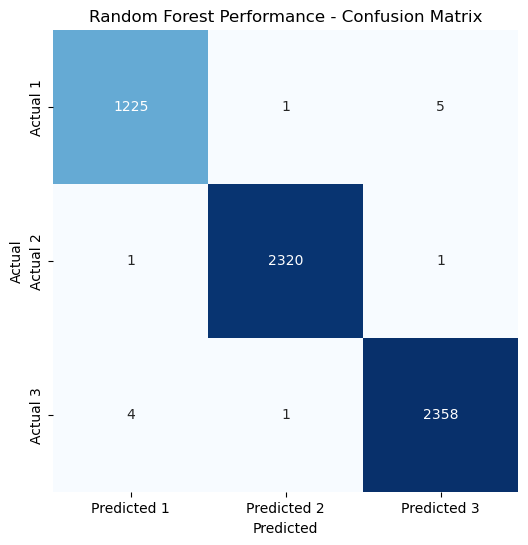


Random Forest Performance - Classification Report

              precision    recall  f1-score   support

           1       1.00      1.00      1.00      1231
           2       1.00      1.00      1.00      2322
           3       1.00      1.00      1.00      2363

    accuracy                           1.00      5916
   macro avg       1.00      1.00      1.00      5916
weighted avg       1.00      1.00      1.00      5916



In [48]:
from evaluation import full_analysis_with_visuals

encoder = None

full_analysis_with_visuals(
    model_name=model_name,
    model_func=model_func,
    results=results,
    best_method=best_method,
    X_test=X_test,
    y_test=y_test,
    encoder=encoder,
    title=f"{model_name} Performance",
    binary=False
)

#### KNN

In [6]:
import evaluation
from supervised import knn_model

model_name = "KNN"
model_func = knn_model

results, best_method = evaluation.evaluate_model_with_sampling(
    model_func, model_name, X_train, y_train, encode=False
)
print(f"Best Sampling Method: {best_method}")
print(f"Results: {results}")




Evaluating KNN...
Applying SMOTE for oversampling...
Data normalized using 'standard' method (NumPy array).
Équilibrage effectué avec SMOTE (oversampling).
Running KNN grid search...
KNN (Oversampling): Best Params: {'metric': 'manhattan', 'n_neighbors': 9, 'weights': 'distance'}
Accuracy for KNN (Oversampling): 0.4682
Applying NearMiss for undersampling...
Data normalized using 'standard' method (NumPy array).
Équilibrage effectué avec NearMiss (undersampling).
Running KNN grid search...
KNN (Undersampling): Best Params: {'metric': 'manhattan', 'n_neighbors': 9, 'weights': 'uniform'}
Accuracy for KNN (Undersampling): 0.3925
Applying SMOTETomek for combination...
Data normalized using 'standard' method (NumPy array).
Équilibrage effectué avec SMOTETomek (combination).
Running KNN grid search...
KNN (Combination): Best Params: {'metric': 'manhattan', 'n_neighbors': 9, 'weights': 'distance'}
Accuracy for KNN (Combination): 0.2081

Best Sampling Method for KNN: Oversampling with Accuracy


Training the best model (Oversampling) with parameters: {'metric': 'manhattan', 'n_neighbors': 9, 'weights': 'distance'}
Data is a numpy array. Skipping categorical encoding.
Data normalized using 'standard' method (NumPy array).
Running KNN grid search...


c:\Users\Rania\anaconda3\envs\basee\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Rania\anaconda3\envs\basee\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Rania\anaconda3\envs\basee\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


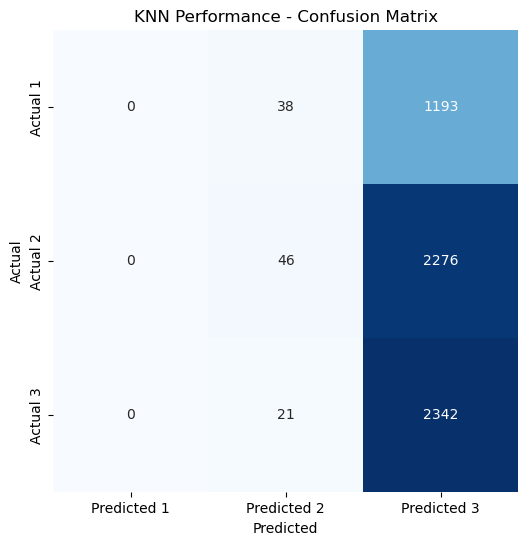


KNN Performance - Classification Report

              precision    recall  f1-score   support

           1       0.00      0.00      0.00      1231
           2       0.44      0.02      0.04      2322
           3       0.40      0.99      0.57      2363

    accuracy                           0.40      5916
   macro avg       0.28      0.34      0.20      5916
weighted avg       0.33      0.40      0.24      5916



In [7]:
from evaluation import full_analysis_with_visuals

encoder = None

full_analysis_with_visuals(
    model_name=model_name,
    model_func=model_func,
    results=results,
    best_method=best_method,
    X_test=X_test,
    y_test=y_test,
    encoder=encoder,
    title=f"{model_name} Performance",
    binary=False
)


#### Xtra Trees

In [ ]:
import evaluation
from supervised import extra_trees_model

model_name = "Extra Trees"
model_func = extra_trees_model

results, best_method = evaluation.evaluate_model_with_sampling(
    model_func, model_name, X_train, y_train, encode=False
)
print(f"Best Sampling Method: {best_method}")
print(f"Results: {results}")




Evaluating Extra Trees...
Applying SMOTE for oversampling...
Équilibrage effectué avec SMOTE (oversampling).
Running Extra Trees grid search...
Extra Trees (Oversampling): Best Params: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
Accuracy for Extra Trees (Oversampling): 0.2136
Applying NearMiss for undersampling...
Équilibrage effectué avec NearMiss (undersampling).
Running Extra Trees grid search...
Extra Trees (Undersampling): Best Params: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Accuracy for Extra Trees (Undersampling): 0.9338
Applying SMOTETomek for combination...
Équilibrage effectué avec SMOTETomek (combination).
Running Extra Trees grid search...
Extra Trees (Combination): Best Params: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}
Accuracy for Extra Trees (Combination): 0.9946

Best Sampling Method for Extra Trees: Combination with Accuracy: 0.9946
Best Sampling Method: Combination
Results: {'Oversampling': {'Best P


Training the best model (Combination) with parameters: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}
Data is a numpy array. Skipping categorical encoding.
Running Extra Trees grid search...


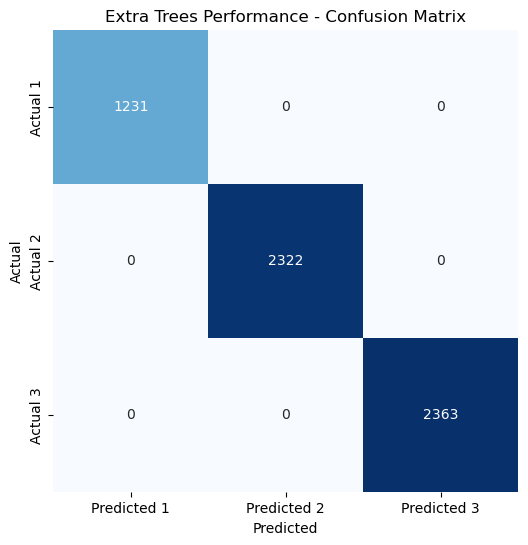


Extra Trees Performance - Classification Report

              precision    recall  f1-score   support

           1       1.00      1.00      1.00      1231
           2       1.00      1.00      1.00      2322
           3       1.00      1.00      1.00      2363

    accuracy                           1.00      5916
   macro avg       1.00      1.00      1.00      5916
weighted avg       1.00      1.00      1.00      5916



In [ ]:
from evaluation import full_analysis_with_visuals

encoder = None

full_analysis_with_visuals(
    model_name=model_name,
    model_func=model_func,
    results=results,
    best_method=best_method,
    X_test=X_test,
    y_test=y_test,
    encoder=encoder,
    title=f"{model_name} Performance",
    binary=False
)


In [ ]:
from evaluation import full_analysis_with_visuals

encoder = None

full_analysis_with_visuals(
    model_name=model_name,
    model_func=model_func,
    results=results,
    best_method=best_method,
    X_test=X_test,
    y_test=y_test,
    encoder=encoder,
    title=f"{model_name} Performance",
    binary=False
)


#### AdaBoost

In [10]:
import evaluation
from supervised import adaboost_model

model_name = "AdaBoost"
model_func = adaboost_model

results, best_method = evaluation.evaluate_model_with_sampling(
    model_func, model_name, X_train, y_train, encode=False
)
print(f"Best Sampling Method: {best_method}")
print(f"Results: {results}")





Evaluating AdaBoost...
Applying SMOTE for oversampling...
Équilibrage effectué avec SMOTE (oversampling).
Running AdaBoost grid search...
AdaBoost (Oversampling): Best Params: {'learning_rate': 0.2, 'n_estimators': 200}
Accuracy for AdaBoost (Oversampling): 0.2081
Applying NearMiss for undersampling...
Équilibrage effectué avec NearMiss (undersampling).
Running AdaBoost grid search...
AdaBoost (Undersampling): Best Params: {'learning_rate': 0.2, 'n_estimators': 200}
Accuracy for AdaBoost (Undersampling): 0.8278
Applying SMOTETomek for combination...
Équilibrage effectué avec SMOTETomek (combination).
Running AdaBoost grid search...
AdaBoost (Combination): Best Params: {'learning_rate': 0.2, 'n_estimators': 200}
Accuracy for AdaBoost (Combination): 0.8536

Best Sampling Method for AdaBoost: Combination with Accuracy: 0.8536
Best Sampling Method: Combination
Results: {'Oversampling': {'Best Params': {'learning_rate': 0.2, 'n_estimators': 200}, 'Accuracy': 0.20810086225635824}, 'Undersam


Training the best model (Combination) with parameters: {'learning_rate': 0.2, 'n_estimators': 200}
Data is a numpy array. Skipping categorical encoding.
Running AdaBoost grid search...


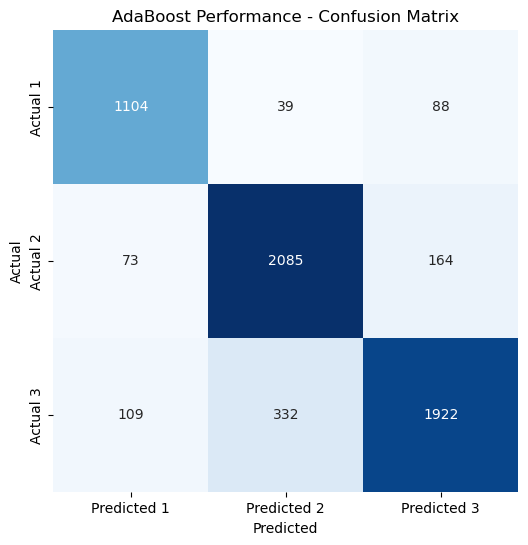


AdaBoost Performance - Classification Report

              precision    recall  f1-score   support

           1       0.86      0.90      0.88      1231
           2       0.85      0.90      0.87      2322
           3       0.88      0.81      0.85      2363

    accuracy                           0.86      5916
   macro avg       0.86      0.87      0.87      5916
weighted avg       0.86      0.86      0.86      5916



In [11]:
from evaluation import full_analysis_with_visuals

encoder = None

full_analysis_with_visuals(
    model_name=model_name,
    model_func=model_func,
    results=results,
    best_method=best_method,
    X_test=X_test,
    y_test=y_test,
    encoder=encoder,
    title=f"{model_name} Performance",
    binary=False
)

#### Naiive Bayes

In [ ]:
import evaluation
from supervised import naive_bayes_model

model_name = "Naive Bayes"
model_func = naive_bayes_model

results, best_method = evaluation.evaluate_model_with_sampling(
    model_func, model_name, X_train, y_train, encode=False
)
print(f"Best Sampling Method: {best_method}")
print(f"Results: {results}")





Evaluating Naive Bayes...
Applying SMOTE for oversampling...
Équilibrage effectué avec SMOTE (oversampling).
Fitting Naive Bayes...
Naive Bayes (Oversampling): Best Params: None
Accuracy for Naive Bayes (Oversampling): 0.3994
Applying NearMiss for undersampling...
Équilibrage effectué avec NearMiss (undersampling).
Fitting Naive Bayes...
Naive Bayes (Undersampling): Best Params: None
Accuracy for Naive Bayes (Undersampling): 0.7579
Applying SMOTETomek for combination...
Équilibrage effectué avec SMOTETomek (combination).
Fitting Naive Bayes...
Naive Bayes (Combination): Best Params: None
Accuracy for Naive Bayes (Combination): 0.7576

Best Sampling Method for Naive Bayes: Undersampling with Accuracy: 0.7579
Best Sampling Method: Undersampling
Results: {'Oversampling': {'Best Params': None, 'Accuracy': 0.39939134845301066}, 'Undersampling': {'Best Params': None, 'Accuracy': 0.7579160930367365}, 'Combination': {'Best Params': None, 'Accuracy': 0.7576262589667415}}



Training the best model (Undersampling) with parameters: None
Data is a numpy array. Skipping categorical encoding.
Fitting Naive Bayes...


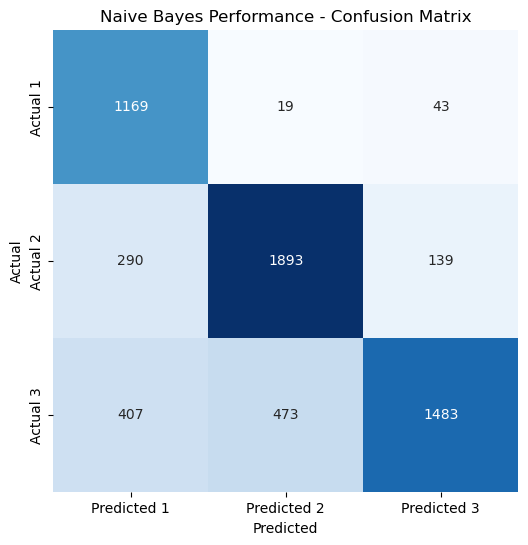


Naive Bayes Performance - Classification Report

              precision    recall  f1-score   support

           1       0.63      0.95      0.75      1231
           2       0.79      0.82      0.80      2322
           3       0.89      0.63      0.74      2363

    accuracy                           0.77      5916
   macro avg       0.77      0.80      0.77      5916
weighted avg       0.80      0.77      0.77      5916



In [ ]:
from evaluation import full_analysis_with_visuals

encoder = None

full_analysis_with_visuals(
    model_name=model_name,
    model_func=model_func,
    results=results,
    best_method=best_method,
    X_test=X_test,
    y_test=y_test,
    encoder=encoder,
    title=f"{model_name} Performance",
    binary=False
)

#### LDA

In [ ]:
import evaluation
from supervised import lda_model

model_name = "LDA"
model_func = lda_model

results, best_method = evaluation.evaluate_model_with_sampling(
    model_func, model_name, X_train, y_train, encode=False
)
print(f"Best Sampling Method: {best_method}")
print(f"Results: {results}")




Evaluating LDA...
Applying SMOTE for oversampling...
Équilibrage effectué avec SMOTE (oversampling).
Fitting LDA...
LDA (Oversampling): Best Params: None
Accuracy for LDA (Oversampling): 0.4027
Applying NearMiss for undersampling...
Équilibrage effectué avec NearMiss (undersampling).
Fitting LDA...
LDA (Undersampling): Best Params: None
Accuracy for LDA (Undersampling): 0.8673
Applying SMOTETomek for combination...
Équilibrage effectué avec SMOTETomek (combination).
Fitting LDA...
LDA (Combination): Best Params: None
Accuracy for LDA (Combination): 0.8825

Best Sampling Method for LDA: Combination with Accuracy: 0.8825
Best Sampling Method: Combination
Results: {'Oversampling': {'Best Params': None, 'Accuracy': 0.40272444025795234}, 'Undersampling': {'Best Params': None, 'Accuracy': 0.8673284544598218}, 'Combination': {'Best Params': None, 'Accuracy': 0.8824722846170567}}



Training the best model (Combination) with parameters: None
Data is a numpy array. Skipping categorical encoding.
Fitting LDA...


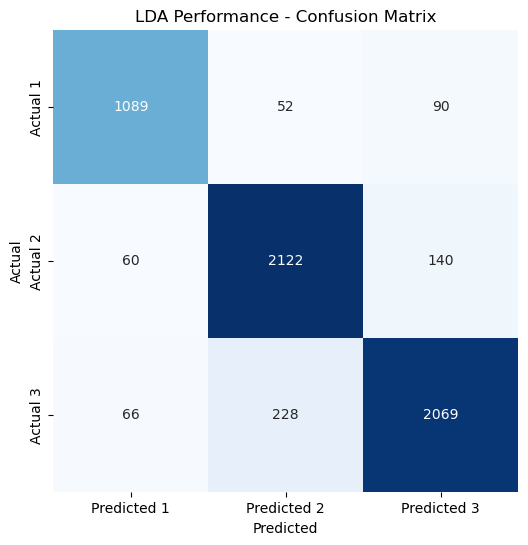


LDA Performance - Classification Report

              precision    recall  f1-score   support

           1       0.90      0.88      0.89      1231
           2       0.88      0.91      0.90      2322
           3       0.90      0.88      0.89      2363

    accuracy                           0.89      5916
   macro avg       0.89      0.89      0.89      5916
weighted avg       0.89      0.89      0.89      5916



In [ ]:
from evaluation import full_analysis_with_visuals

encoder = None

full_analysis_with_visuals(
    model_name=model_name,
    model_func=model_func,
    results=results,
    best_method=best_method,
    X_test=X_test,
    y_test=y_test,
    encoder=encoder,
    title=f"{model_name} Performance",
    binary=False
)


#### QDA

In [ ]:
import evaluation
from supervised import qda_model

model_name = "QDA"
model_func = qda_model

results, best_method = evaluation.evaluate_model_with_sampling(
    model_func, model_name, X_train, y_train, encode=False
)
print(f"Best Sampling Method: {best_method}")
print(f"Results: {results}")




Evaluating QDA...
Applying SMOTE for oversampling...
Équilibrage effectué avec SMOTE (oversampling).
Fitting QDA...


c:\Users\Rania\anaconda3\envs\basee\lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning:

Variables are collinear



QDA (Oversampling): Best Params: None
Accuracy for QDA (Oversampling): 0.3994
Applying NearMiss for undersampling...
Équilibrage effectué avec NearMiss (undersampling).
Fitting QDA...


c:\Users\Rania\anaconda3\envs\basee\lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning:

Variables are collinear



QDA (Undersampling): Best Params: None
Accuracy for QDA (Undersampling): 0.8030
Applying SMOTETomek for combination...
Équilibrage effectué avec SMOTETomek (combination).
Fitting QDA...


c:\Users\Rania\anaconda3\envs\basee\lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning:

Variables are collinear



QDA (Combination): Best Params: None
Accuracy for QDA (Combination): 0.8198

Best Sampling Method for QDA: Combination with Accuracy: 0.8198
Best Sampling Method: Combination
Results: {'Oversampling': {'Best Params': None, 'Accuracy': 0.39939134845301066}, 'Undersampling': {'Best Params': None, 'Accuracy': 0.8029852909209477}, 'Combination': {'Best Params': None, 'Accuracy': 0.8197956669806535}}



Training the best model (Combination) with parameters: None
Data is a numpy array. Skipping categorical encoding.
Fitting QDA...


c:\Users\Rania\anaconda3\envs\basee\lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning:

Variables are collinear



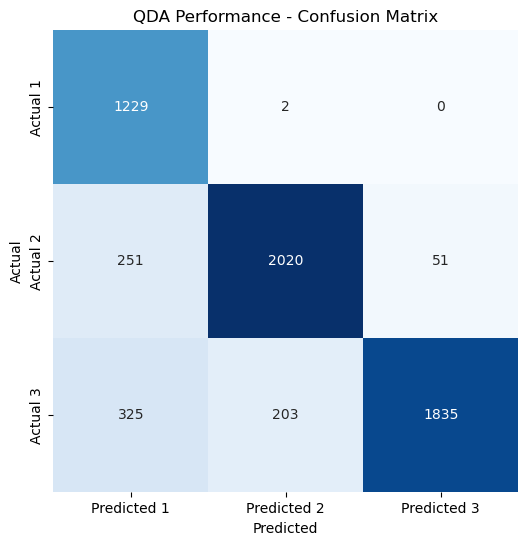


QDA Performance - Classification Report

              precision    recall  f1-score   support

           1       0.68      1.00      0.81      1231
           2       0.91      0.87      0.89      2322
           3       0.97      0.78      0.86      2363

    accuracy                           0.86      5916
   macro avg       0.85      0.88      0.85      5916
weighted avg       0.89      0.86      0.86      5916



In [ ]:
from evaluation import full_analysis_with_visuals

encoder = None

full_analysis_with_visuals(
    model_name=model_name,
    model_func=model_func,
    results=results,
    best_method=best_method,
    X_test=X_test,
    y_test=y_test,
    encoder=encoder,
    title=f"{model_name} Performance",
    binary=False
)


### Aproche 2 : 
 2. Une Combinaison des informations W et X ; M=D^(-1)*W*X, où D est une matrice
 diagonale, chaque valeur diagonale correspond à la somme des valeurs d’une ligne
 de W.

Critique : 

Cette approche \( M = D^{-1} W X \), bien qu'élégante et prometteuse pour combiner des informations structurelles et des caractéristiques individuelles, présente plusieurs forces et faiblesses. Voici une critique détaillée de cette méthode :



###### **Limites de l'approche :**

1. **Hypothèse implicite d'homogénéité :**
   - L’approche suppose que les **voisins immédiats d’un nœud (définis par \( W \)) ont des caractéristiques similaires**.
   - Cela n’est pas toujours vrai, surtout dans des graphes hétérogènes où des nœuds connectés peuvent appartenir à des classes ou catégories différentes.
   - Par exemple, dans PubMed, une publication citant une autre ne garantit pas qu'elles partagent la même thématique.

2. **Propagation aveugle de l’information :**
   - La multiplication \( W X \) **ne prend pas en compte l’importance relative des connexions** (par exemple, certains liens dans \( W \) pourraient être plus significatifs que d’autres).
   - Tous les liens ont la même pondération, ce qui peut entraîner une dilution de l’information pertinente.

3. **Sensibilité aux données bruitées :**
   - Si la matrice \( W \) contient des **connexions erronées ou non pertinentes**, elles influencent négativement les représentations finales dans \( M \).
   - Cela peut amplifier les erreurs dans les données de graphe ou des caractéristiques.1m

4. **Perte d’information individuelle :**
   - La multiplication \( D^{-1} W X \) force chaque nœud à partager ses caractéristiques avec ses voisins.
   - Cela peut conduire à une perte de **spécificité locale** pour les nœuds qui ont des propriétés uniques ou rares.

5. **Manque de prise en compte des hiérarchies du graphe :**
   - Cette méthode ne va pas au-delà des **voisins directs (1-hop neighbors)**.
   - Elle ne capture pas les **relations à plusieurs degrés (2-hop, 3-hop, etc.)**, ce qui limite son efficacité dans les grands réseaux.

6. **Effet d'explosion des degrés faibles :**
   - Les nœuds avec un faible degré (peu de connexions) se retrouvent très influencés par leurs rares voisins, ce qui peut biaiser leur représentation.

7. **Absence de mécanisme non-linéaire :**
   - La méthode se limite à une combinaison linéaire des caractéristiques, ce qui peut être insuffisant pour capturer des relations complexes entre les nœuds et leurs voisins.
   - Par exemple, elle ne peut pas apprendre des interactions plus riches entre les variables comme le feraient des modèles de type **Graph Neural Networks (GNN)**.

8. **Problème d’échelle :**
   - Pour des graphes très larges, le calcul explicite de \( D^{-1} W X \) peut être coûteux en mémoire et en temps.
   - La multiplication matricielle nécessite une gestion efficace pour les graphes denses ou de grande taille.



In [10]:
import numpy as np
from scipy.sparse import diags

def combine_w_and_x(W, X):
    """
    Combine adjacency matrix W and feature matrix X using the formula:
    M = D^(-1) * W * X, where D is a diagonal matrix with row sums of W.
    
    Parameters:
    - W: Adjacency matrix (numpy array or sparse matrix), shape (n, n).
    - X: Feature matrix (numpy array), shape (n, d).
    
    Returns:
    - M: Combined matrix, shape (n, d).
    """
    # Ensure W is in the correct format (numpy array or sparse)
    if not isinstance(W, np.ndarray):
        W = W.toarray()
    
    # Compute the diagonal matrix D
    row_sums = np.sum(W, axis=1)  # Sum of each row
    D_inv = diags(1 / row_sums)  # Inverse of D (diagonal matrix)
    
    # Compute the combined matrix M = D^(-1) * W * X
    M = D_inv @ W @ X
    
    return M


In [11]:
from sklearn.model_selection import train_test_split
# Combine W_pubmed and X_pubmed
M_pubmed = combine_w_and_x(W_pubmed, X_pubmed)

# Check the shape of the resulting matrix
print(f"Shape of combined matrix M: {M_pubmed.shape}")

# Split the combined matrix into training and testing sets
X_train_M, X_test_M, y_train_M, y_test_M = train_test_split(
    M_pubmed, gnd_pubmed, test_size=0.2, random_state=42, stratify=gnd_pubmed
)

# Check the shapes of the splits
print(f"Train shape: {X_train_M.shape}, Test shape: {X_test_M.shape}")


Shape of combined matrix M: (19717, 500)
Train shape: (15773, 500), Test shape: (3944, 500)


#### Logistic Regression

In [12]:
import evaluation
from supervised import logistic_regression_model

# Step 1: Define the model name and function
model_name = "Logistic Regression"
model_func = logistic_regression_model

# Step 2: Evaluate the model with sampling
results, best_method = evaluation.evaluate_model_with_sampling(
    model_func, model_name, X_train_M, y_train_M, encode=False
)
print(f"Best Sampling Method: {best_method}")
print(f"Results: {results}")





Evaluating Logistic Regression...
Applying SMOTE for oversampling...
Équilibrage effectué avec SMOTE (oversampling).
Running Logistic Regression grid search...
Best Params: {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}
Logistic Regression (Oversampling): Best Params: {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}
Accuracy for Logistic Regression (Oversampling): 0.3994
Applying NearMiss for undersampling...
Équilibrage effectué avec NearMiss (undersampling).
Running Logistic Regression grid search...


c:\Users\Rania\anaconda3\envs\basee\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Best Params: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
Logistic Regression (Undersampling): Best Params: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
Accuracy for Logistic Regression (Undersampling): 0.8128
Applying SMOTETomek for combination...
Équilibrage effectué avec SMOTETomek (combination).
Running Logistic Regression grid search...
Best Params: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
Logistic Regression (Combination): Best Params: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
Accuracy for Logistic Regression (Combination): 0.8317

Best Sampling Method for Logistic Regression: Combination with Accuracy: 0.8317
Best Sampling Method: Combination
Results: {'Oversampling': {'Best Params': {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}, 'Accuracy': 0.3994167247828568}, 'Undersampling': {'Best Params': {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}, 'Accuracy': 0.8127813351930514}, 'Combination': {'Best Params': {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}, 'Accuracy': 0.83

c:\Users\Rania\anaconda3\envs\basee\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Training the best model (Combination) with parameters: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
Data is a numpy array. Skipping categorical encoding.
Running Logistic Regression grid search...


c:\Users\Rania\anaconda3\envs\basee\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Best Params: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}


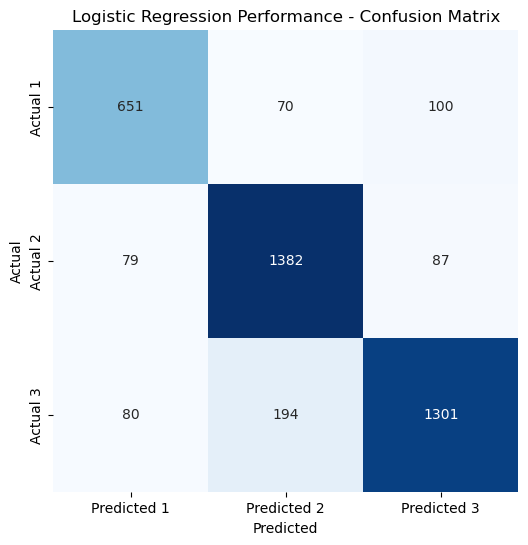


Logistic Regression Performance - Classification Report

              precision    recall  f1-score   support

           1       0.80      0.79      0.80       821
           2       0.84      0.89      0.87      1548
           3       0.87      0.83      0.85      1575

    accuracy                           0.85      3944
   macro avg       0.84      0.84      0.84      3944
weighted avg       0.85      0.85      0.85      3944



In [13]:
# Step 3: Perform a full analysis with visualizations
from evaluation import full_analysis_with_visuals

# Logistic Regression does not need an encoder as encode=False
encoder = None

full_analysis_with_visuals(
    model_name=model_name,
    model_func=model_func,
    results=results,
    best_method=best_method,
    X_test=X_test_M,
    y_test=y_test_M,
    encoder=encoder,
    title=f"{model_name} Performance",
    binary=False  # Set to True if binary classification
)

#### Decision Treea

In [14]:
import evaluation
from supervised import *


import evaluation

model_name = "Decision Tree"
model_func = decision_tree_model  # Replace with any model function
results, best_method = evaluation.evaluate_model_with_sampling(model_func, model_name, X_train_M, y_train_M, encode= False)
print(f"Best Sampling Method: {best_method}")
print(f"Results: {results}")




Evaluating Decision Tree...
Applying SMOTE for oversampling...
Équilibrage effectué avec SMOTE (oversampling).
Running Decision Tree grid search...
Decision Tree (Oversampling): Best Params: {'max_depth': 20, 'min_samples_split': 2}
Accuracy for Decision Tree (Oversampling): 0.3987
Applying NearMiss for undersampling...
Équilibrage effectué avec NearMiss (undersampling).
Running Decision Tree grid search...
Decision Tree (Undersampling): Best Params: {'max_depth': 10, 'min_samples_split': 5}
Accuracy for Decision Tree (Undersampling): 0.7724
Applying SMOTETomek for combination...
Équilibrage effectué avec SMOTETomek (combination).
Running Decision Tree grid search...
Decision Tree (Combination): Best Params: {'max_depth': 20, 'min_samples_split': 2}
Accuracy for Decision Tree (Combination): 0.9132

Best Sampling Method for Decision Tree: Combination with Accuracy: 0.9132
Best Sampling Method: Combination
Results: {'Oversampling': {'Best Params': {'max_depth': 20, 'min_samples_split': 


Training the best model (Combination) with parameters: {'max_depth': 20, 'min_samples_split': 2}
Data is a numpy array. Skipping categorical encoding.
Running Decision Tree grid search...


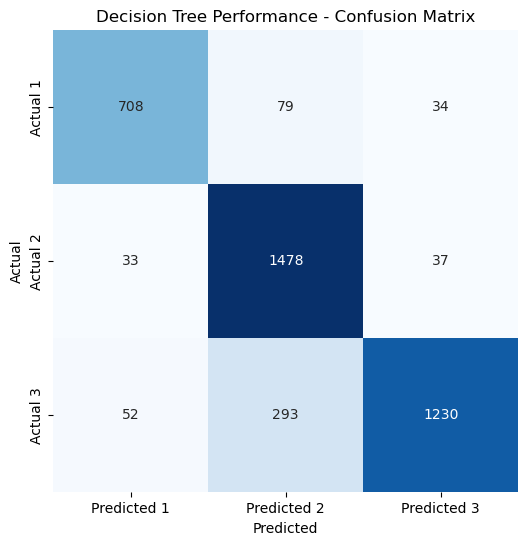


Decision Tree Performance - Classification Report

              precision    recall  f1-score   support

           1       0.89      0.86      0.88       821
           2       0.80      0.95      0.87      1548
           3       0.95      0.78      0.86      1575

    accuracy                           0.87      3944
   macro avg       0.88      0.87      0.87      3944
weighted avg       0.88      0.87      0.87      3944



In [15]:
from evaluation import full_analysis_with_visuals

# Assuming an encoder was trained during preprocessing (if necessary)
encoder = None

full_analysis_with_visuals(
    model_name=model_name,
    model_func=model_func,
    results=results,
    best_method=best_method,
    X_test=X_test_M,
    y_test=y_test_M,
    encoder=encoder,
    title=f"{model_name} Performance",
    binary=False  # Set to True if binary classification
)


#### Random forest

In [16]:
import evaluation
from supervised import random_forest_model

model_name = "Random Forest"
model_func = random_forest_model

results, best_method = evaluation.evaluate_model_with_sampling(
    model_func, model_name, X_train_M, y_train_M, encode=False
)
print(f"Best Sampling Method: {best_method}")
print(f"Results: {results}")





Evaluating Random Forest...
Applying SMOTE for oversampling...
Équilibrage effectué avec SMOTE (oversampling).
Running Random Forest grid search...
Random Forest (Oversampling): Best Params: {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 200}
Accuracy for Random Forest (Oversampling): 0.3994
Applying NearMiss for undersampling...
Équilibrage effectué avec NearMiss (undersampling).
Running Random Forest grid search...
Random Forest (Undersampling): Best Params: {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 200}
Accuracy for Random Forest (Undersampling): 0.8570
Applying SMOTETomek for combination...
Équilibrage effectué avec SMOTETomek (combination).
Running Random Forest grid search...
Random Forest (Combination): Best Params: {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 200}
Accuracy for Random Forest (Combination): 0.9223

Best Sampling Method for Random Forest: Combination with Accuracy: 0.9223
Best Sampling Method: Combination
Results: {'Oversam


Training the best model (Combination) with parameters: {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 200}
Data is a numpy array. Skipping categorical encoding.
Running Random Forest grid search...


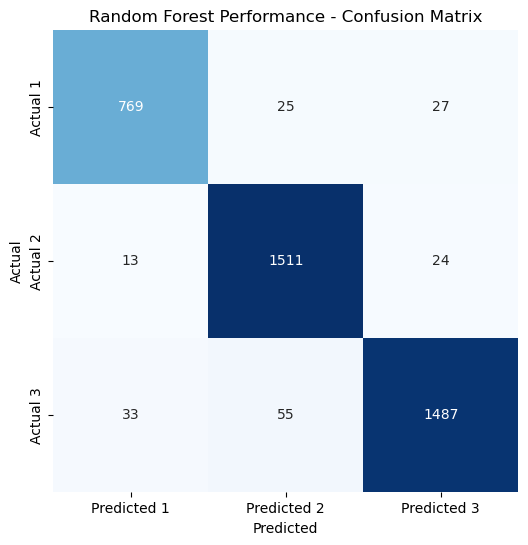


Random Forest Performance - Classification Report

              precision    recall  f1-score   support

           1       0.94      0.94      0.94       821
           2       0.95      0.98      0.96      1548
           3       0.97      0.94      0.96      1575

    accuracy                           0.96      3944
   macro avg       0.95      0.95      0.95      3944
weighted avg       0.96      0.96      0.96      3944



In [17]:
from evaluation import full_analysis_with_visuals

encoder = None

full_analysis_with_visuals(
    model_name=model_name,
    model_func=model_func,
    results=results,
    best_method=best_method,
    X_test=X_test_M,
    y_test=y_test_M,
    encoder=encoder,
    title=f"{model_name} Performance",
    binary=False
)

#### KNN

In [18]:
import evaluation
from supervised import knn_model

model_name = "KNN"
model_func = knn_model

results, best_method = evaluation.evaluate_model_with_sampling(
    model_func, model_name, X_train_M, y_train_M, encode=False
)
print(f"Best Sampling Method: {best_method}")
print(f"Results: {results}")




Evaluating KNN...
Applying SMOTE for oversampling...
Data normalized using 'standard' method (NumPy array).
Équilibrage effectué avec SMOTE (oversampling).
Running KNN grid search...
KNN (Oversampling): Best Params: {'metric': 'manhattan', 'n_neighbors': 9, 'weights': 'distance'}
Accuracy for KNN (Oversampling): 0.3925
Applying NearMiss for undersampling...
Data normalized using 'standard' method (NumPy array).
Équilibrage effectué avec NearMiss (undersampling).
Running KNN grid search...
KNN (Undersampling): Best Params: {'metric': 'manhattan', 'n_neighbors': 9, 'weights': 'uniform'}
Accuracy for KNN (Undersampling): 0.3925
Applying SMOTETomek for combination...
Data normalized using 'standard' method (NumPy array).
Équilibrage effectué avec SMOTETomek (combination).
Running KNN grid search...
KNN (Combination): Best Params: {'metric': 'manhattan', 'n_neighbors': 9, 'weights': 'distance'}
Accuracy for KNN (Combination): 0.3925

Best Sampling Method for KNN: Oversampling with Accuracy


Training the best model (Oversampling) with parameters: {'metric': 'manhattan', 'n_neighbors': 9, 'weights': 'distance'}
Data is a numpy array. Skipping categorical encoding.
Data normalized using 'standard' method (NumPy array).
Running KNN grid search...


c:\Users\Rania\anaconda3\envs\basee\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Rania\anaconda3\envs\basee\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Rania\anaconda3\envs\basee\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


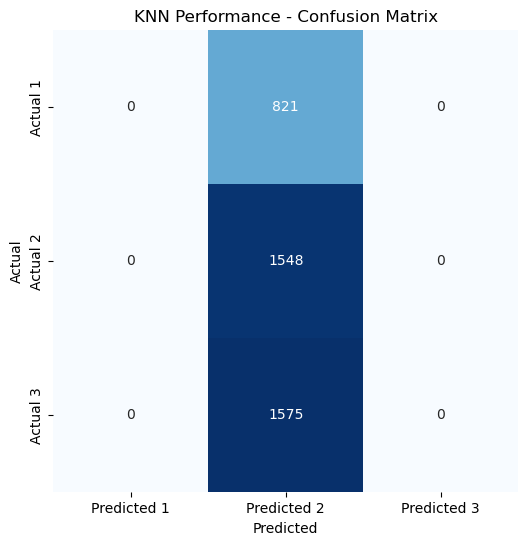


KNN Performance - Classification Report

              precision    recall  f1-score   support

           1       0.00      0.00      0.00       821
           2       0.39      1.00      0.56      1548
           3       0.00      0.00      0.00      1575

    accuracy                           0.39      3944
   macro avg       0.13      0.33      0.19      3944
weighted avg       0.15      0.39      0.22      3944



In [19]:
from evaluation import full_analysis_with_visuals

encoder = None

full_analysis_with_visuals(
    model_name=model_name,
    model_func=model_func,
    results=results,
    best_method=best_method,
    X_test=X_test_M,
    y_test=y_test_M,
    encoder=encoder,
    title=f"{model_name} Performance",
    binary=False
)


#### Xtra Trees

In [ ]:
import evaluation
from supervised import extra_trees_model

model_name = "Extra Trees"
model_func = extra_trees_model

results, best_method = evaluation.evaluate_model_with_sampling(
    model_func, model_name, X_train_M, y_train_M, encode=False
)
print(f"Best Sampling Method: {best_method}")
print(f"Results: {results}")




Evaluating Extra Trees...
Applying SMOTE for oversampling...
Équilibrage effectué avec SMOTE (oversampling).
Running Extra Trees grid search...



Training the best model (Combination) with parameters: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}
Data is a numpy array. Skipping categorical encoding.
Running Extra Trees grid search...


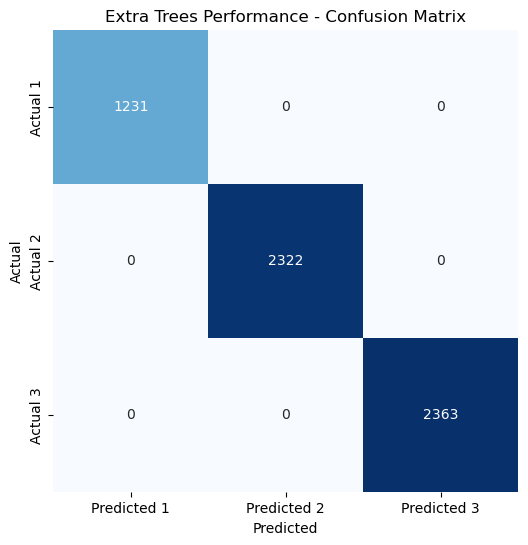


Extra Trees Performance - Classification Report

              precision    recall  f1-score   support

           1       1.00      1.00      1.00      1231
           2       1.00      1.00      1.00      2322
           3       1.00      1.00      1.00      2363

    accuracy                           1.00      5916
   macro avg       1.00      1.00      1.00      5916
weighted avg       1.00      1.00      1.00      5916



In [ ]:
from evaluation import full_analysis_with_visuals

encoder = None

full_analysis_with_visuals(
    model_name=model_name,
    model_func=model_func,
    results=results,
    best_method=best_method,
    X_test=X_test_M,
    y_test=y_test_M,
    encoder=encoder,
    title=f"{model_name} Performance",
    binary=False
)


#### AdaBoost

In [ ]:
import evaluation
from supervised import adaboost_model

model_name = "AdaBoost"
model_func = adaboost_model

results, best_method = evaluation.evaluate_model_with_sampling(
    model_func, model_name, X_train_M, y_train_M, encode=False
)
print(f"Best Sampling Method: {best_method}")
print(f"Results: {results}")





Evaluating AdaBoost...
Applying SMOTE for oversampling...
Équilibrage effectué avec SMOTE (oversampling).
Running AdaBoost grid search...
AdaBoost (Oversampling): Best Params: {'learning_rate': 0.2, 'n_estimators': 200}
Accuracy for AdaBoost (Oversampling): 0.2081
Applying NearMiss for undersampling...
Équilibrage effectué avec NearMiss (undersampling).
Running AdaBoost grid search...
AdaBoost (Undersampling): Best Params: {'learning_rate': 0.2, 'n_estimators': 200}
Accuracy for AdaBoost (Undersampling): 0.8278
Applying SMOTETomek for combination...
Équilibrage effectué avec SMOTETomek (combination).
Running AdaBoost grid search...
AdaBoost (Combination): Best Params: {'learning_rate': 0.2, 'n_estimators': 200}
Accuracy for AdaBoost (Combination): 0.8536

Best Sampling Method for AdaBoost: Combination with Accuracy: 0.8536
Best Sampling Method: Combination
Results: {'Oversampling': {'Best Params': {'learning_rate': 0.2, 'n_estimators': 200}, 'Accuracy': 0.20810086225635824}, 'Undersam


Training the best model (Combination) with parameters: {'learning_rate': 0.2, 'n_estimators': 200}
Data is a numpy array. Skipping categorical encoding.
Running AdaBoost grid search...


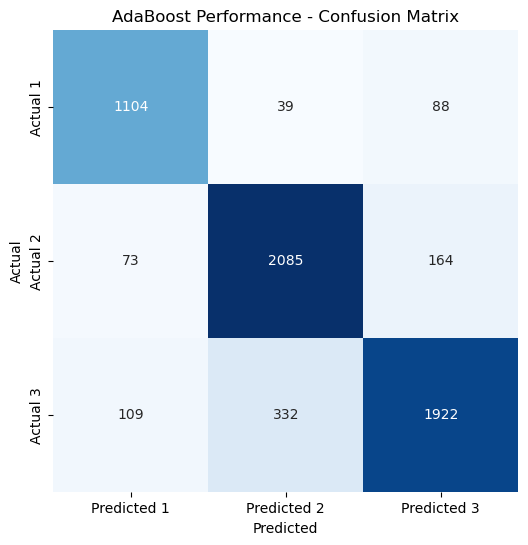


AdaBoost Performance - Classification Report

              precision    recall  f1-score   support

           1       0.86      0.90      0.88      1231
           2       0.85      0.90      0.87      2322
           3       0.88      0.81      0.85      2363

    accuracy                           0.86      5916
   macro avg       0.86      0.87      0.87      5916
weighted avg       0.86      0.86      0.86      5916



In [ ]:
from evaluation import full_analysis_with_visuals

encoder = None

full_analysis_with_visuals(
    model_name=model_name,
    model_func=model_func,
    results=results,
    best_method=best_method,
    X_test=X_test_M,
    y_test=y_test_M,
    encoder=encoder,
    title=f"{model_name} Performance",
    binary=False
)

#### Naiive Bayes

In [ ]:
import evaluation
from supervised import naive_bayes_model

model_name = "Naive Bayes"
model_func = naive_bayes_model

results, best_method = evaluation.evaluate_model_with_sampling(
    model_func, model_name, X_train_M, y_train_M, encode=False
)
print(f"Best Sampling Method: {best_method}")
print(f"Results: {results}")





Evaluating Naive Bayes...
Applying SMOTE for oversampling...
Équilibrage effectué avec SMOTE (oversampling).
Fitting Naive Bayes...
Naive Bayes (Oversampling): Best Params: None
Accuracy for Naive Bayes (Oversampling): 0.3994
Applying NearMiss for undersampling...
Équilibrage effectué avec NearMiss (undersampling).
Fitting Naive Bayes...
Naive Bayes (Undersampling): Best Params: None
Accuracy for Naive Bayes (Undersampling): 0.7579
Applying SMOTETomek for combination...
Équilibrage effectué avec SMOTETomek (combination).
Fitting Naive Bayes...
Naive Bayes (Combination): Best Params: None
Accuracy for Naive Bayes (Combination): 0.7576

Best Sampling Method for Naive Bayes: Undersampling with Accuracy: 0.7579
Best Sampling Method: Undersampling
Results: {'Oversampling': {'Best Params': None, 'Accuracy': 0.39939134845301066}, 'Undersampling': {'Best Params': None, 'Accuracy': 0.7579160930367365}, 'Combination': {'Best Params': None, 'Accuracy': 0.7576262589667415}}



Training the best model (Undersampling) with parameters: None
Data is a numpy array. Skipping categorical encoding.
Fitting Naive Bayes...


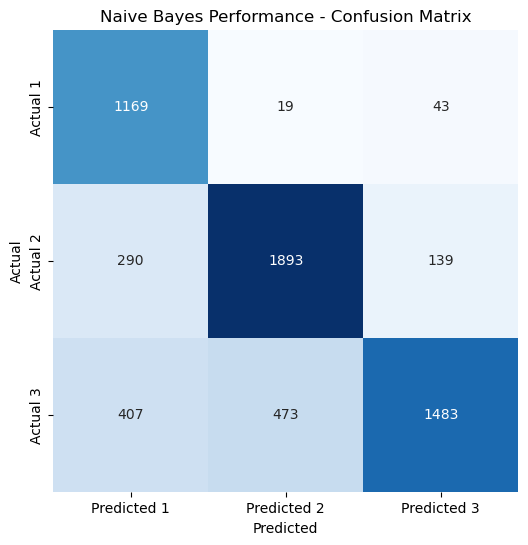


Naive Bayes Performance - Classification Report

              precision    recall  f1-score   support

           1       0.63      0.95      0.75      1231
           2       0.79      0.82      0.80      2322
           3       0.89      0.63      0.74      2363

    accuracy                           0.77      5916
   macro avg       0.77      0.80      0.77      5916
weighted avg       0.80      0.77      0.77      5916



In [ ]:
from evaluation import full_analysis_with_visuals

encoder = None

full_analysis_with_visuals(
    model_name=model_name,
    model_func=model_func,
    results=results,
    best_method=best_method,
    X_test=X_test_M,
    y_test=y_test_M,
    encoder=encoder,
    title=f"{model_name} Performance",
    binary=False
)

#### LDA

In [ ]:
import evaluation
from supervised import lda_model

model_name = "LDA"
model_func = lda_model

results, best_method = evaluation.evaluate_model_with_sampling(
    model_func, model_name, X_train_M, y_train_M, encode=False
)
print(f"Best Sampling Method: {best_method}")
print(f"Results: {results}")




Evaluating LDA...
Applying SMOTE for oversampling...
Équilibrage effectué avec SMOTE (oversampling).
Fitting LDA...
LDA (Oversampling): Best Params: None
Accuracy for LDA (Oversampling): 0.4027
Applying NearMiss for undersampling...
Équilibrage effectué avec NearMiss (undersampling).
Fitting LDA...
LDA (Undersampling): Best Params: None
Accuracy for LDA (Undersampling): 0.8673
Applying SMOTETomek for combination...
Équilibrage effectué avec SMOTETomek (combination).
Fitting LDA...
LDA (Combination): Best Params: None
Accuracy for LDA (Combination): 0.8825

Best Sampling Method for LDA: Combination with Accuracy: 0.8825
Best Sampling Method: Combination
Results: {'Oversampling': {'Best Params': None, 'Accuracy': 0.40272444025795234}, 'Undersampling': {'Best Params': None, 'Accuracy': 0.8673284544598218}, 'Combination': {'Best Params': None, 'Accuracy': 0.8824722846170567}}



Training the best model (Combination) with parameters: None
Data is a numpy array. Skipping categorical encoding.
Fitting LDA...


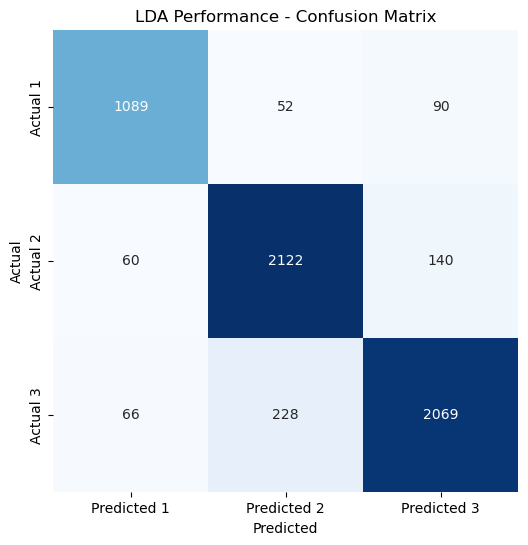


LDA Performance - Classification Report

              precision    recall  f1-score   support

           1       0.90      0.88      0.89      1231
           2       0.88      0.91      0.90      2322
           3       0.90      0.88      0.89      2363

    accuracy                           0.89      5916
   macro avg       0.89      0.89      0.89      5916
weighted avg       0.89      0.89      0.89      5916



In [ ]:
from evaluation import full_analysis_with_visuals

encoder = None

full_analysis_with_visuals(
    model_name=model_name,
    model_func=model_func,
    results=results,
    best_method=best_method,
    X_test=X_test_M,
    y_test=y_test_M,
    encoder=encoder,
    title=f"{model_name} Performance",
    binary=False
)


#### QDA

In [ ]:
import evaluation
from supervised import qda_model

model_name = "QDA"
model_func = qda_model

results, best_method = evaluation.evaluate_model_with_sampling(
    model_func, model_name, X_train_M, y_train_M, encode=False
)
print(f"Best Sampling Method: {best_method}")
print(f"Results: {results}")




Evaluating QDA...
Applying SMOTE for oversampling...
Équilibrage effectué avec SMOTE (oversampling).
Fitting QDA...


c:\Users\Rania\anaconda3\envs\basee\lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning:

Variables are collinear



QDA (Oversampling): Best Params: None
Accuracy for QDA (Oversampling): 0.3994
Applying NearMiss for undersampling...
Équilibrage effectué avec NearMiss (undersampling).
Fitting QDA...


c:\Users\Rania\anaconda3\envs\basee\lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning:

Variables are collinear



QDA (Undersampling): Best Params: None
Accuracy for QDA (Undersampling): 0.8030
Applying SMOTETomek for combination...
Équilibrage effectué avec SMOTETomek (combination).
Fitting QDA...


c:\Users\Rania\anaconda3\envs\basee\lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning:

Variables are collinear



QDA (Combination): Best Params: None
Accuracy for QDA (Combination): 0.8198

Best Sampling Method for QDA: Combination with Accuracy: 0.8198
Best Sampling Method: Combination
Results: {'Oversampling': {'Best Params': None, 'Accuracy': 0.39939134845301066}, 'Undersampling': {'Best Params': None, 'Accuracy': 0.8029852909209477}, 'Combination': {'Best Params': None, 'Accuracy': 0.8197956669806535}}



Training the best model (Combination) with parameters: None
Data is a numpy array. Skipping categorical encoding.
Fitting QDA...


c:\Users\Rania\anaconda3\envs\basee\lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning:

Variables are collinear



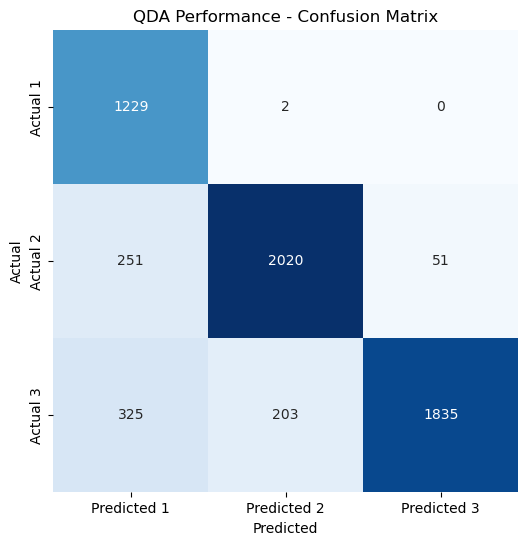


QDA Performance - Classification Report

              precision    recall  f1-score   support

           1       0.68      1.00      0.81      1231
           2       0.91      0.87      0.89      2322
           3       0.97      0.78      0.86      2363

    accuracy                           0.86      5916
   macro avg       0.85      0.88      0.85      5916
weighted avg       0.89      0.86      0.86      5916



In [ ]:
from evaluation import full_analysis_with_visuals

encoder = None

full_analysis_with_visuals(
    model_name=model_name,
    model_func=model_func,
    results=results,
    best_method=best_method,
    X_test=X_test_M,
    y_test=y_test_M,
    encoder=encoder,
    title=f"{model_name} Performance",
    binary=False
)


### Aproche 3 : 
 3. Discuter d’autres idées pour combiner et aligner les deux types d’information.


Explication de la formule :

\[
M = \sigma \left( D^{-1/2} W D^{-1/2} X \Theta \right)
\]

1. **Normalisation symétrique** (\( D^{-1/2} W D^{-1/2} \)):
   - \( D \) est la matrice diagonale des degrés (\( D_{ii} = \sum_j W_{ij} \)).
   - \( D^{-1/2} W D^{-1/2} \) est une version normalisée symétrique de \( W \).
   - **Avantage :** Cela empêche les nœuds à degrés élevés (hubs) de dominer les calculs et réduit l'effet des nœuds à faibles degrés (problème d'explosion ou de dilution).

2. **Apprentissage paramétrique** (\( \Theta \)):
   - \( \Theta \) est une matrice de poids (paramètres appris) qui permet de moduler les relations entre les caractéristiques.
   - **Avantage :** Contrairement à \( WX \), où la combinaison des caractéristiques est linéaire et statique, cette matrice permet d'apprendre des relations spécifiques à chaque application ou jeu de données.

3. **Activation non linéaire** (\( \sigma \)):
   - Une fonction non linéaire (comme ReLU ou Sigmoid) est appliquée après la multiplication matricielle.
   - **Avantage :** Cela permet de capturer des interactions complexes entre les caractéristiques et les relations dans le graphe, ce qui est impossible avec une simple combinaison linéaire.

### Étape par étape de la méthode :

1. **Normalisation symétrique (\( D^{-1/2} W D^{-1/2} \)):**
   - Cette normalisation symétrique ajuste les poids des connexions dans \( W \) pour que chaque lien soit pondéré proportionnellement à l'importance des nœuds qu'il relie.
   - Cela équilibre la contribution des nœuds à degrés faibles et élevés.

2. **Multiplication avec \( X \):**
   - La multiplication \( W X \) (ajustée par la normalisation symétrique) diffuse les informations des caractéristiques de chaque nœud vers ses voisins.
   - Contrairement à \( D^{-1} W X \), cette diffusion est équilibrée par la normalisation symétrique, réduisant les biais.

3. **Ajout de paramètres (\( \Theta \)):**
   - \( \Theta \) ajuste dynamiquement l'influence des différentes caractéristiques.
   - Par exemple, certaines caractéristiques dans \( X \) peuvent être moins pertinentes pour une tâche donnée, et \( \Theta \) peut apprendre à les réduire.

4. **Non-linéarité (\( \sigma \)):**
   - Après la diffusion, une activation non linéaire est appliquée.
   - Cela permet au modèle de capturer des interactions non linéaires entre les caractéristiques des nœuds et les relations du graphe.

#### Pourquoi cette formule résout les problèmes :

1. **Propagation équilibrée :**
   - La normalisation symétrique (\( D^{-1/2} W D^{-1/2} \)) réduit la domination des nœuds à hauts degrés (hubs), évitant que des nœuds avec de nombreuses connexions biaisent la représentation.

2. **Non-linéarité :**
   - L’activation non linéaire (\( \sigma \)) permet de modéliser des relations complexes entre les nœuds et leurs voisins, contrairement à une simple combinaison linéaire.

3. **Apprentissage adaptatif :**
   - La matrice \( \Theta \) introduit des paramètres apprenables qui ajustent dynamiquement la contribution des caractéristiques, augmentant ainsi la flexibilité de la méthode.

4. **Robustesse au bruit :**
   - Si \( W \) contient des connexions erronées ou bruitées, la combinaison pondérée avec \( \Theta \) peut atténuer leur impact.

5. **Capture des hiérarchies :**
   - Si la formule est répétée sur plusieurs couches (comme dans un **Graph Neural Network**, voir ci-dessous), elle peut capturer des relations à plusieurs sauts (\( W^2, W^3 \), etc.), contrairement à l’approche classique qui se limite aux voisins directs.

In [ ]:
import numpy as np
from scipy.sparse import diags
from scipy.special import expit  # Sigmoid function

def combine_w_x_theta(W, X, Theta):
    """
    Combine adjacency matrix W, feature matrix X, and weight matrix Theta using:
    M = σ(D^(-1/2) * W * D^(-1/2) * X * Θ)
    where σ is the sigmoid activation function.
    
    Parameters:
    - W: Adjacency matrix (numpy array or sparse matrix), shape (n, n).
    - X: Feature matrix (numpy array), shape (n, d).
    - Theta: Weight matrix (numpy array), shape (d, k).
    
    Returns:
    - M: Combined matrix, shape (n, k).
    """
    # Ensure W is in the correct format (numpy array or sparse)
    if not isinstance(W, np.ndarray):
        W = W.toarray()
    
    # Compute the diagonal matrix D
    row_sums = np.sum(W, axis=1)  # Sum of each row
    D_inv_sqrt = diags(1 / np.sqrt(row_sums))  # D^(-1/2)
    
    # Compute normalized adjacency matrix D^(-1/2) * W * D^(-1/2)
    W_normalized = D_inv_sqrt @ W @ D_inv_sqrt
    
    # Combine with features and weights: D^(-1/2) * W * D^(-1/2) * X * Θ
    Z = W_normalized @ X @ Theta
    
    # Apply the sigmoid activation function σ
    M = expit(Z)  # Element-wise sigmoid
    
    return M


In [ ]:
# Define the weight matrix Theta (d x k)
Theta = np.random.randn(X_pubmed.shape[1], 10)  # Example: k=10 output dimensions

# Combine W, X, and Theta
M_pubmed_new = combine_w_x_theta(W_pubmed, X_pubmed, Theta)

# Check the shape of the resulting matrix
print(f"Shape of combined matrix M: {M_pubmed_new.shape}")
from sklearn.model_selection import train_test_split

# Split the new combined matrix into training and testing sets
X_train_M, X_test_M, y_train_M, y_test_M = train_test_split(
    M_pubmed_new, gnd_pubmed, test_size=0.2, random_state=42, stratify=gnd_pubmed
)

# Check the shapes of the splits
print(f"Train shape: {X_train_M.shape}, Test shape: {X_test_M.shape}")


Shape of combined matrix M: (19717, 10)
Train shape: (15773, 10), Test shape: (3944, 10)


#### Logistic Regression

In [ ]:
import evaluation
from supervised import logistic_regression_model

# Step 1: Define the model name and function
model_name = "Logistic Regression"
model_func = logistic_regression_model

# Step 2: Evaluate the model with sampling
results, best_method = evaluation.evaluate_model_with_sampling(
    model_func, model_name, X_train_M, y_train_M, encode=False
)
print(f"Best Sampling Method: {best_method}")
print(f"Results: {results}")





Evaluating Logistic Regression...
Applying SMOTE for oversampling...
Équilibrage effectué avec SMOTE (oversampling).
Running Logistic Regression grid search...
Best Params: {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}
Logistic Regression (Oversampling): Best Params: {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}
Accuracy for Logistic Regression (Oversampling): 0.3994
Applying NearMiss for undersampling...
Équilibrage effectué avec NearMiss (undersampling).
Running Logistic Regression grid search...


c:\Users\Rania\anaconda3\envs\basee\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Best Params: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
Logistic Regression (Undersampling): Best Params: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
Accuracy for Logistic Regression (Undersampling): 0.8128
Applying SMOTETomek for combination...
Équilibrage effectué avec SMOTETomek (combination).
Running Logistic Regression grid search...
Best Params: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
Logistic Regression (Combination): Best Params: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
Accuracy for Logistic Regression (Combination): 0.8317

Best Sampling Method for Logistic Regression: Combination with Accuracy: 0.8317
Best Sampling Method: Combination
Results: {'Oversampling': {'Best Params': {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}, 'Accuracy': 0.3994167247828568}, 'Undersampling': {'Best Params': {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}, 'Accuracy': 0.8127813351930514}, 'Combination': {'Best Params': {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}, 'Accuracy': 0.83

c:\Users\Rania\anaconda3\envs\basee\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Training the best model (Combination) with parameters: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
Data is a numpy array. Skipping categorical encoding.
Running Logistic Regression grid search...


c:\Users\Rania\anaconda3\envs\basee\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Best Params: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}


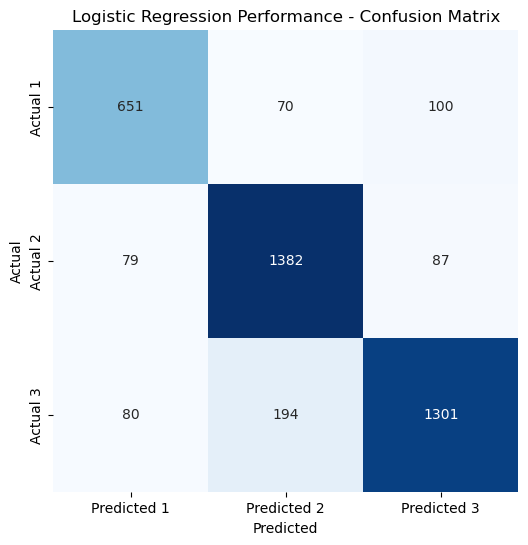


Logistic Regression Performance - Classification Report

              precision    recall  f1-score   support

           1       0.80      0.79      0.80       821
           2       0.84      0.89      0.87      1548
           3       0.87      0.83      0.85      1575

    accuracy                           0.85      3944
   macro avg       0.84      0.84      0.84      3944
weighted avg       0.85      0.85      0.85      3944



In [ ]:
# Step 3: Perform a full analysis with visualizations
from evaluation import full_analysis_with_visuals

# Logistic Regression does not need an encoder as encode=False
encoder = None

full_analysis_with_visuals(
    model_name=model_name,
    model_func=model_func,
    results=results,
    best_method=best_method,
    X_test=X_test_M,
    y_test=y_test_M,
    encoder=encoder,
    title=f"{model_name} Performance",
    binary=False  # Set to True if binary classification
)

#### Decision Treea

In [ ]:
import evaluation
from supervised import *


import evaluation

model_name = "Decision Tree"
model_func = decision_tree_model  # Replace with any model function
results, best_method = evaluation.evaluate_model_with_sampling(model_func, model_name, X_train_M, y_train_M, encode= False)
print(f"Best Sampling Method: {best_method}")
print(f"Results: {results}")




Evaluating Decision Tree...
Applying SMOTE for oversampling...
Équilibrage effectué avec SMOTE (oversampling).
Running Decision Tree grid search...
Decision Tree (Oversampling): Best Params: {'max_depth': 20, 'min_samples_split': 2}
Accuracy for Decision Tree (Oversampling): 0.3987
Applying NearMiss for undersampling...
Équilibrage effectué avec NearMiss (undersampling).
Running Decision Tree grid search...
Decision Tree (Undersampling): Best Params: {'max_depth': 10, 'min_samples_split': 5}
Accuracy for Decision Tree (Undersampling): 0.7724
Applying SMOTETomek for combination...
Équilibrage effectué avec SMOTETomek (combination).
Running Decision Tree grid search...
Decision Tree (Combination): Best Params: {'max_depth': 20, 'min_samples_split': 2}
Accuracy for Decision Tree (Combination): 0.9132

Best Sampling Method for Decision Tree: Combination with Accuracy: 0.9132
Best Sampling Method: Combination
Results: {'Oversampling': {'Best Params': {'max_depth': 20, 'min_samples_split': 


Training the best model (Combination) with parameters: {'max_depth': 20, 'min_samples_split': 2}
Data is a numpy array. Skipping categorical encoding.
Running Decision Tree grid search...


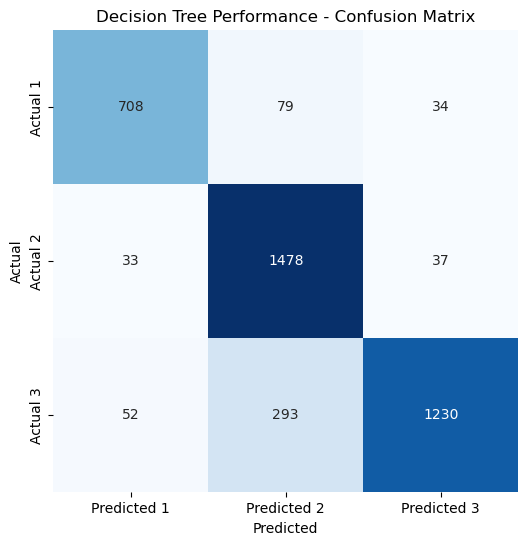


Decision Tree Performance - Classification Report

              precision    recall  f1-score   support

           1       0.89      0.86      0.88       821
           2       0.80      0.95      0.87      1548
           3       0.95      0.78      0.86      1575

    accuracy                           0.87      3944
   macro avg       0.88      0.87      0.87      3944
weighted avg       0.88      0.87      0.87      3944



In [ ]:
from evaluation import full_analysis_with_visuals

# Assuming an encoder was trained during preprocessing (if necessary)
encoder = None

full_analysis_with_visuals(
    model_name=model_name,
    model_func=model_func,
    results=results,
    best_method=best_method,
    X_test=X_test_M,
    y_test=y_test_M,
    encoder=encoder,
    title=f"{model_name} Performance",
    binary=False  # Set to True if binary classification
)


#### Random forest

In [ ]:
import evaluation
from supervised import random_forest_model

model_name = "Random Forest"
model_func = random_forest_model

results, best_method = evaluation.evaluate_model_with_sampling(
    model_func, model_name, X_train_M, y_train_M, encode=False
)
print(f"Best Sampling Method: {best_method}")
print(f"Results: {results}")





Evaluating Random Forest...
Applying SMOTE for oversampling...
Équilibrage effectué avec SMOTE (oversampling).
Running Random Forest grid search...
Random Forest (Oversampling): Best Params: {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 200}
Accuracy for Random Forest (Oversampling): 0.3994
Applying NearMiss for undersampling...
Équilibrage effectué avec NearMiss (undersampling).
Running Random Forest grid search...
Random Forest (Undersampling): Best Params: {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 200}
Accuracy for Random Forest (Undersampling): 0.8570
Applying SMOTETomek for combination...
Équilibrage effectué avec SMOTETomek (combination).
Running Random Forest grid search...
Random Forest (Combination): Best Params: {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 200}
Accuracy for Random Forest (Combination): 0.9223

Best Sampling Method for Random Forest: Combination with Accuracy: 0.9223
Best Sampling Method: Combination
Results: {'Oversam

In [ ]:
from evaluation import full_analysis_with_visuals

encoder = None

full_analysis_with_visuals(
    model_name=model_name,
    model_func=model_func,
    results=results,
    best_method=best_method,
    X_test=X_test_M,
    y_test=y_test_M,
    encoder=encoder,
    title=f"{model_name} Performance",
    binary=False
)

#### KNN

In [ ]:
import evaluation
from supervised import knn_model

model_name = "KNN"
model_func = knn_model

results, best_method = evaluation.evaluate_model_with_sampling(
    model_func, model_name, X_train_M, y_train_M, encode=False
)
print(f"Best Sampling Method: {best_method}")
print(f"Results: {results}")




Evaluating KNN...
Applying SMOTE for oversampling...
Data normalized using 'standard' method (NumPy array).
Équilibrage effectué avec SMOTE (oversampling).
Running KNN grid search...
KNN (Oversampling): Best Params: {'metric': 'manhattan', 'n_neighbors': 9, 'weights': 'distance'}
Accuracy for KNN (Oversampling): 0.4682
Applying NearMiss for undersampling...
Data normalized using 'standard' method (NumPy array).
Équilibrage effectué avec NearMiss (undersampling).
Running KNN grid search...
KNN (Undersampling): Best Params: {'metric': 'manhattan', 'n_neighbors': 9, 'weights': 'uniform'}
Accuracy for KNN (Undersampling): 0.3925
Applying SMOTETomek for combination...
Data normalized using 'standard' method (NumPy array).
Équilibrage effectué avec SMOTETomek (combination).
Running KNN grid search...
KNN (Combination): Best Params: {'metric': 'manhattan', 'n_neighbors': 9, 'weights': 'distance'}
Accuracy for KNN (Combination): 0.2081

Best Sampling Method for KNN: Oversampling with Accuracy


Training the best model (Oversampling) with parameters: {'metric': 'manhattan', 'n_neighbors': 9, 'weights': 'distance'}
Data is a numpy array. Skipping categorical encoding.
Data normalized using 'standard' method (NumPy array).
Running KNN grid search...


c:\Users\Rania\anaconda3\envs\basee\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Rania\anaconda3\envs\basee\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Rania\anaconda3\envs\basee\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


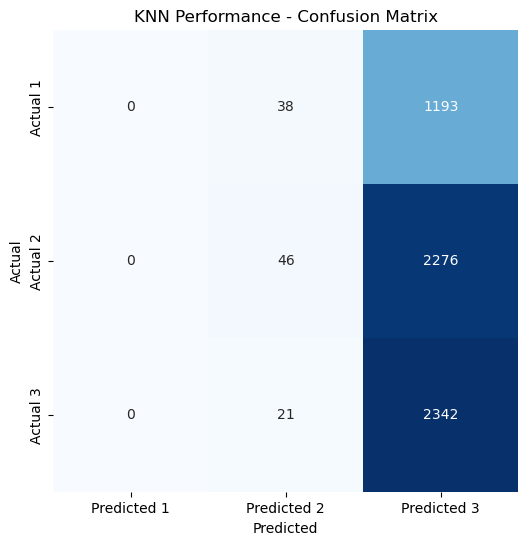


KNN Performance - Classification Report

              precision    recall  f1-score   support

           1       0.00      0.00      0.00      1231
           2       0.44      0.02      0.04      2322
           3       0.40      0.99      0.57      2363

    accuracy                           0.40      5916
   macro avg       0.28      0.34      0.20      5916
weighted avg       0.33      0.40      0.24      5916



In [ ]:
from evaluation import full_analysis_with_visuals

encoder = None

full_analysis_with_visuals(
    model_name=model_name,
    model_func=model_func,
    results=results,
    best_method=best_method,
    X_test=X_test_M,
    y_test=y_test_M,
    encoder=encoder,
    title=f"{model_name} Performance",
    binary=False
)


#### Xtra Trees

In [ ]:
import evaluation
from supervised import extra_trees_model

model_name = "Extra Trees"
model_func = extra_trees_model

results, best_method = evaluation.evaluate_model_with_sampling(
    model_func, model_name, X_train_M, y_train_M, encode=False
)
print(f"Best Sampling Method: {best_method}")
print(f"Results: {results}")




Evaluating Extra Trees...
Applying SMOTE for oversampling...
Équilibrage effectué avec SMOTE (oversampling).
Running Extra Trees grid search...
Extra Trees (Oversampling): Best Params: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
Accuracy for Extra Trees (Oversampling): 0.2136
Applying NearMiss for undersampling...
Équilibrage effectué avec NearMiss (undersampling).
Running Extra Trees grid search...
Extra Trees (Undersampling): Best Params: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Accuracy for Extra Trees (Undersampling): 0.9338
Applying SMOTETomek for combination...
Équilibrage effectué avec SMOTETomek (combination).
Running Extra Trees grid search...
Extra Trees (Combination): Best Params: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}
Accuracy for Extra Trees (Combination): 0.9946

Best Sampling Method for Extra Trees: Combination with Accuracy: 0.9946
Best Sampling Method: Combination
Results: {'Oversampling': {'Best P


Training the best model (Combination) with parameters: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}
Data is a numpy array. Skipping categorical encoding.
Running Extra Trees grid search...


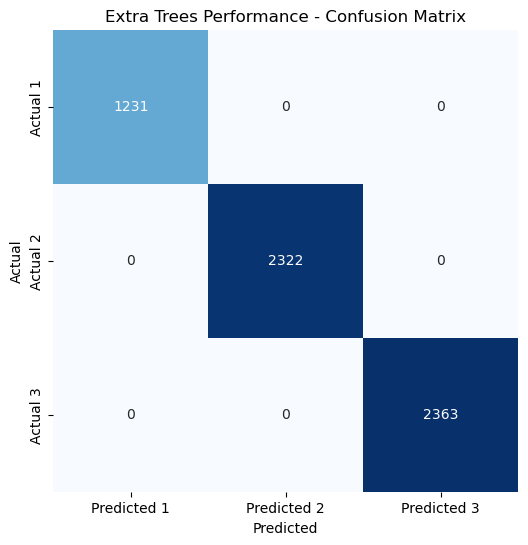


Extra Trees Performance - Classification Report

              precision    recall  f1-score   support

           1       1.00      1.00      1.00      1231
           2       1.00      1.00      1.00      2322
           3       1.00      1.00      1.00      2363

    accuracy                           1.00      5916
   macro avg       1.00      1.00      1.00      5916
weighted avg       1.00      1.00      1.00      5916



In [ ]:
from evaluation import full_analysis_with_visuals

encoder = None

full_analysis_with_visuals(
    model_name=model_name,
    model_func=model_func,
    results=results,
    best_method=best_method,
    X_test=X_test_M,
    y_test=y_test_M,
    encoder=encoder,
    title=f"{model_name} Performance",
    binary=False
)


#### AdaBoost

In [ ]:
import evaluation
from supervised import adaboost_model

model_name = "AdaBoost"
model_func = adaboost_model

results, best_method = evaluation.evaluate_model_with_sampling(
    model_func, model_name, X_train_M, y_train_M, encode=False
)
print(f"Best Sampling Method: {best_method}")
print(f"Results: {results}")





Evaluating AdaBoost...
Applying SMOTE for oversampling...
Équilibrage effectué avec SMOTE (oversampling).
Running AdaBoost grid search...
AdaBoost (Oversampling): Best Params: {'learning_rate': 0.2, 'n_estimators': 200}
Accuracy for AdaBoost (Oversampling): 0.2081
Applying NearMiss for undersampling...
Équilibrage effectué avec NearMiss (undersampling).
Running AdaBoost grid search...
AdaBoost (Undersampling): Best Params: {'learning_rate': 0.2, 'n_estimators': 200}
Accuracy for AdaBoost (Undersampling): 0.8278
Applying SMOTETomek for combination...
Équilibrage effectué avec SMOTETomek (combination).
Running AdaBoost grid search...
AdaBoost (Combination): Best Params: {'learning_rate': 0.2, 'n_estimators': 200}
Accuracy for AdaBoost (Combination): 0.8536

Best Sampling Method for AdaBoost: Combination with Accuracy: 0.8536
Best Sampling Method: Combination
Results: {'Oversampling': {'Best Params': {'learning_rate': 0.2, 'n_estimators': 200}, 'Accuracy': 0.20810086225635824}, 'Undersam


Training the best model (Combination) with parameters: {'learning_rate': 0.2, 'n_estimators': 200}
Data is a numpy array. Skipping categorical encoding.
Running AdaBoost grid search...


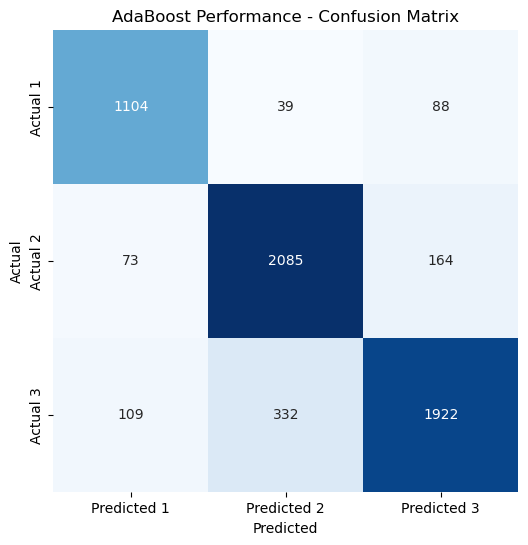


AdaBoost Performance - Classification Report

              precision    recall  f1-score   support

           1       0.86      0.90      0.88      1231
           2       0.85      0.90      0.87      2322
           3       0.88      0.81      0.85      2363

    accuracy                           0.86      5916
   macro avg       0.86      0.87      0.87      5916
weighted avg       0.86      0.86      0.86      5916



In [ ]:
from evaluation import full_analysis_with_visuals

encoder = None

full_analysis_with_visuals(
    model_name=model_name,
    model_func=model_func,
    results=results,
    best_method=best_method,
    X_test=X_test_M,
    y_test=y_test_M,
    encoder=encoder,
    title=f"{model_name} Performance",
    binary=False
)

#### Naiive Bayes

In [ ]:
import evaluation
from supervised import naive_bayes_model

model_name = "Naive Bayes"
model_func = naive_bayes_model

results, best_method = evaluation.evaluate_model_with_sampling(
    model_func, model_name, X_train_M, y_train_M, encode=False
)
print(f"Best Sampling Method: {best_method}")
print(f"Results: {results}")





Evaluating Naive Bayes...
Applying SMOTE for oversampling...
Équilibrage effectué avec SMOTE (oversampling).
Fitting Naive Bayes...
Naive Bayes (Oversampling): Best Params: None
Accuracy for Naive Bayes (Oversampling): 0.3994
Applying NearMiss for undersampling...
Équilibrage effectué avec NearMiss (undersampling).
Fitting Naive Bayes...
Naive Bayes (Undersampling): Best Params: None
Accuracy for Naive Bayes (Undersampling): 0.7579
Applying SMOTETomek for combination...
Équilibrage effectué avec SMOTETomek (combination).
Fitting Naive Bayes...
Naive Bayes (Combination): Best Params: None
Accuracy for Naive Bayes (Combination): 0.7576

Best Sampling Method for Naive Bayes: Undersampling with Accuracy: 0.7579
Best Sampling Method: Undersampling
Results: {'Oversampling': {'Best Params': None, 'Accuracy': 0.39939134845301066}, 'Undersampling': {'Best Params': None, 'Accuracy': 0.7579160930367365}, 'Combination': {'Best Params': None, 'Accuracy': 0.7576262589667415}}



Training the best model (Undersampling) with parameters: None
Data is a numpy array. Skipping categorical encoding.
Fitting Naive Bayes...


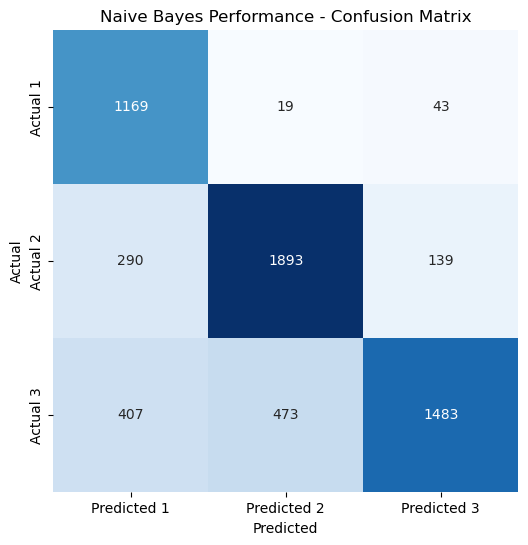


Naive Bayes Performance - Classification Report

              precision    recall  f1-score   support

           1       0.63      0.95      0.75      1231
           2       0.79      0.82      0.80      2322
           3       0.89      0.63      0.74      2363

    accuracy                           0.77      5916
   macro avg       0.77      0.80      0.77      5916
weighted avg       0.80      0.77      0.77      5916



In [ ]:
from evaluation import full_analysis_with_visuals

encoder = None

full_analysis_with_visuals(
    model_name=model_name,
    model_func=model_func,
    results=results,
    best_method=best_method,
    X_test=X_test_M,
    y_test=y_test_M,
    encoder=encoder,
    title=f"{model_name} Performance",
    binary=False
)

#### LDA

In [ ]:
import evaluation
from supervised import lda_model

model_name = "LDA"
model_func = lda_model

results, best_method = evaluation.evaluate_model_with_sampling(
    model_func, model_name, X_train_M, y_train_M, encode=False
)
print(f"Best Sampling Method: {best_method}")
print(f"Results: {results}")




Evaluating LDA...
Applying SMOTE for oversampling...
Équilibrage effectué avec SMOTE (oversampling).
Fitting LDA...
LDA (Oversampling): Best Params: None
Accuracy for LDA (Oversampling): 0.4027
Applying NearMiss for undersampling...
Équilibrage effectué avec NearMiss (undersampling).
Fitting LDA...
LDA (Undersampling): Best Params: None
Accuracy for LDA (Undersampling): 0.8673
Applying SMOTETomek for combination...
Équilibrage effectué avec SMOTETomek (combination).
Fitting LDA...
LDA (Combination): Best Params: None
Accuracy for LDA (Combination): 0.8825

Best Sampling Method for LDA: Combination with Accuracy: 0.8825
Best Sampling Method: Combination
Results: {'Oversampling': {'Best Params': None, 'Accuracy': 0.40272444025795234}, 'Undersampling': {'Best Params': None, 'Accuracy': 0.8673284544598218}, 'Combination': {'Best Params': None, 'Accuracy': 0.8824722846170567}}



Training the best model (Combination) with parameters: None
Data is a numpy array. Skipping categorical encoding.
Fitting LDA...


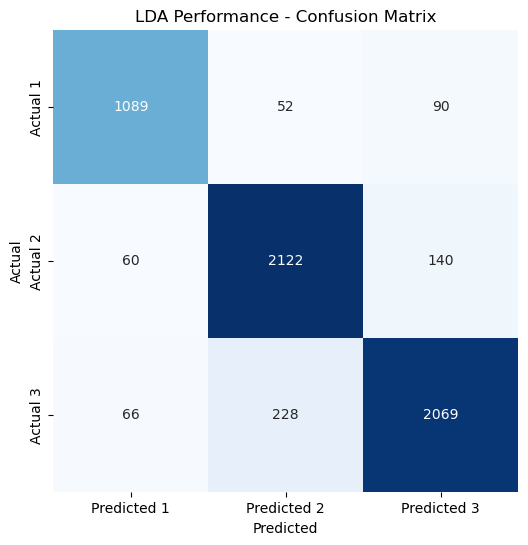


LDA Performance - Classification Report

              precision    recall  f1-score   support

           1       0.90      0.88      0.89      1231
           2       0.88      0.91      0.90      2322
           3       0.90      0.88      0.89      2363

    accuracy                           0.89      5916
   macro avg       0.89      0.89      0.89      5916
weighted avg       0.89      0.89      0.89      5916



In [ ]:
from evaluation import full_analysis_with_visuals

encoder = None

full_analysis_with_visuals(
    model_name=model_name,
    model_func=model_func,
    results=results,
    best_method=best_method,
    X_test=X_test_M,
    y_test=y_test_M,
    encoder=encoder,
    title=f"{model_name} Performance",
    binary=False
)


#### QDA

In [ ]:
import evaluation
from supervised import qda_model

model_name = "QDA"
model_func = qda_model

results, best_method = evaluation.evaluate_model_with_sampling(
    model_func, model_name, X_train_M, y_train_M, encode=False
)
print(f"Best Sampling Method: {best_method}")
print(f"Results: {results}")




Evaluating QDA...
Applying SMOTE for oversampling...
Équilibrage effectué avec SMOTE (oversampling).
Fitting QDA...


c:\Users\Rania\anaconda3\envs\basee\lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning:

Variables are collinear



QDA (Oversampling): Best Params: None
Accuracy for QDA (Oversampling): 0.3994
Applying NearMiss for undersampling...
Équilibrage effectué avec NearMiss (undersampling).
Fitting QDA...


c:\Users\Rania\anaconda3\envs\basee\lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning:

Variables are collinear



QDA (Undersampling): Best Params: None
Accuracy for QDA (Undersampling): 0.8030
Applying SMOTETomek for combination...
Équilibrage effectué avec SMOTETomek (combination).
Fitting QDA...


c:\Users\Rania\anaconda3\envs\basee\lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning:

Variables are collinear



QDA (Combination): Best Params: None
Accuracy for QDA (Combination): 0.8198

Best Sampling Method for QDA: Combination with Accuracy: 0.8198
Best Sampling Method: Combination
Results: {'Oversampling': {'Best Params': None, 'Accuracy': 0.39939134845301066}, 'Undersampling': {'Best Params': None, 'Accuracy': 0.8029852909209477}, 'Combination': {'Best Params': None, 'Accuracy': 0.8197956669806535}}



Training the best model (Combination) with parameters: None
Data is a numpy array. Skipping categorical encoding.
Fitting QDA...


c:\Users\Rania\anaconda3\envs\basee\lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning:

Variables are collinear



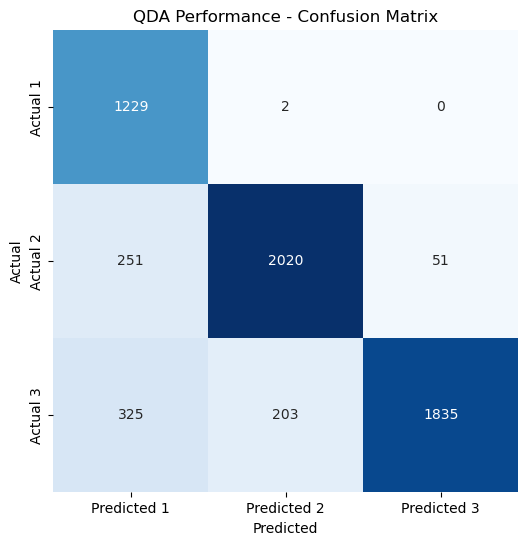


QDA Performance - Classification Report

              precision    recall  f1-score   support

           1       0.68      1.00      0.81      1231
           2       0.91      0.87      0.89      2322
           3       0.97      0.78      0.86      2363

    accuracy                           0.86      5916
   macro avg       0.85      0.88      0.85      5916
weighted avg       0.89      0.86      0.86      5916



In [ ]:
from evaluation import full_analysis_with_visuals

encoder = None

full_analysis_with_visuals(
    model_name=model_name,
    model_func=model_func,
    results=results,
    best_method=best_method,
    X_test=X_test_M,
    y_test=y_test_M,
    encoder=encoder,
    title=f"{model_name} Performance",
    binary=False
)


### Extension avec des couches multiples (inspiration GNN) :

Pour aller encore plus loin, la formule peut être étendue avec des **couches empilées** :

\[
M^{(k)} = \sigma \left( D^{-1/2} W D^{-1/2} M^{(k-1)} \Theta^{(k)} \right), \quad M^{(0)} = X
\]

- \( k \) représente le nombre de couches, et chaque couche apprend une représentation plus riche en capturant des relations à plus longue portée dans le graphe.
- Cette approche est similaire aux **Graph Convolutional Networks (GCN)**.


In [ ]:
def iterative_combination(W, X, thetas, num_iterations):
    """
    Compute iterative representations using:
    M^(k) = σ(D^(-1/2) W D^(-1/2) M^(k-1) Θ^(k)),
    with M^(0) = X.
    
    Parameters:
    - W: Adjacency matrix (numpy array or sparse matrix), shape (n, n).
    - X: Feature matrix, shape (n, d).
    - thetas: List of weight matrices [Θ^(1), Θ^(2), ..., Θ^(k)].
    - num_iterations: Number of iterations (k).
    
    Returns:
    - M: Final representation matrix, shape (n, d_k), where d_k is the output size of Θ^(k).
    """
    from scipy.sparse import diags
    from scipy.special import expit  # Sigmoid function

    # Ensure W is in the correct format (numpy array or sparse)
    if not isinstance(W, np.ndarray):
        W = W.toarray()

    # Compute the diagonal matrix D
    row_sums = np.sum(W, axis=1)
    D_inv_sqrt = diags(1 / np.sqrt(row_sums))  # D^(-1/2)

    # Compute normalized adjacency matrix D^(-1/2) * W * D^(-1/2)
    W_normalized = D_inv_sqrt @ W @ D_inv_sqrt

    # Initialize M^(0) = X
    M = X

    # Perform the iterative computation
    for k in range(num_iterations):
        Theta_k = thetas[k]  # Get Θ^(k)
        M = expit(W_normalized @ M @ Theta_k)  # Apply the formula with sigmoid activation

    return M


In [ ]:
# Define weight matrices Θ^(1), Θ^(2), ..., Θ^(k)
num_iterations = 3  # Example: 3 iterations
input_dim = X_pubmed.shape[1]
hidden_dim = 64  # Number of hidden dimensions
output_dim = 10  # Number of output dimensions
thetas = [np.random.randn(input_dim if i == 0 else hidden_dim, hidden_dim if i < num_iterations - 1 else output_dim)
          for i in range(num_iterations)]

# Perform iterative combination
M_final = iterative_combination(W_pubmed, X_pubmed, thetas, num_iterations)

# Check the shape of the final representation
print(f"Shape of final representation M: {M_final.shape}")


In [ ]:
from sklearn.model_selection import train_test_split

# Split the final representation into training and testing sets
X_train_M, X_test_M, y_train_M, y_test_M = train_test_split(
    M_final, gnd_pubmed, test_size=0.2, random_state=42, stratify=gnd_pubmed
)

# Check the shapes of the splits
print(f"Train shape: {X_train_M.shape}, Test shape: {X_test_M.shape}")


#### Logistic Regression

In [ ]:
import evaluation
from supervised import logistic_regression_model

# Step 1: Define the model name and function
model_name = "Logistic Regression"
model_func = logistic_regression_model

# Step 2: Evaluate the model with sampling
results, best_method = evaluation.evaluate_model_with_sampling(
    model_func, model_name, X_train_M, y_train_M, encode=False
)
print(f"Best Sampling Method: {best_method}")
print(f"Results: {results}")





Evaluating Logistic Regression...
Applying SMOTE for oversampling...
Équilibrage effectué avec SMOTE (oversampling).
Running Logistic Regression grid search...
Best Params: {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}
Logistic Regression (Oversampling): Best Params: {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}
Accuracy for Logistic Regression (Oversampling): 0.3994
Applying NearMiss for undersampling...
Équilibrage effectué avec NearMiss (undersampling).
Running Logistic Regression grid search...


c:\Users\Rania\anaconda3\envs\basee\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Best Params: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
Logistic Regression (Undersampling): Best Params: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
Accuracy for Logistic Regression (Undersampling): 0.8128
Applying SMOTETomek for combination...
Équilibrage effectué avec SMOTETomek (combination).
Running Logistic Regression grid search...
Best Params: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
Logistic Regression (Combination): Best Params: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
Accuracy for Logistic Regression (Combination): 0.8317

Best Sampling Method for Logistic Regression: Combination with Accuracy: 0.8317
Best Sampling Method: Combination
Results: {'Oversampling': {'Best Params': {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}, 'Accuracy': 0.3994167247828568}, 'Undersampling': {'Best Params': {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}, 'Accuracy': 0.8127813351930514}, 'Combination': {'Best Params': {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}, 'Accuracy': 0.83

c:\Users\Rania\anaconda3\envs\basee\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Training the best model (Combination) with parameters: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
Data is a numpy array. Skipping categorical encoding.
Running Logistic Regression grid search...


c:\Users\Rania\anaconda3\envs\basee\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Best Params: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}


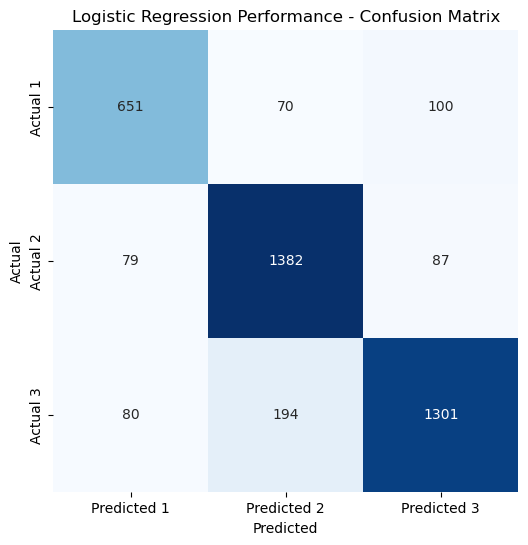


Logistic Regression Performance - Classification Report

              precision    recall  f1-score   support

           1       0.80      0.79      0.80       821
           2       0.84      0.89      0.87      1548
           3       0.87      0.83      0.85      1575

    accuracy                           0.85      3944
   macro avg       0.84      0.84      0.84      3944
weighted avg       0.85      0.85      0.85      3944



In [ ]:
# Step 3: Perform a full analysis with visualizations
from evaluation import full_analysis_with_visuals

# Logistic Regression does not need an encoder as encode=False
encoder = None

full_analysis_with_visuals(
    model_name=model_name,
    model_func=model_func,
    results=results,
    best_method=best_method,
    X_test=X_test_M,
    y_test=y_test_M,
    encoder=encoder,
    title=f"{model_name} Performance",
    binary=False  # Set to True if binary classification
)

#### Decision Treea

In [ ]:
import evaluation
from supervised import *


import evaluation

model_name = "Decision Tree"
model_func = decision_tree_model  # Replace with any model function
results, best_method = evaluation.evaluate_model_with_sampling(model_func, model_name, X_train_M, y_train_M, encode= False)
print(f"Best Sampling Method: {best_method}")
print(f"Results: {results}")




Evaluating Decision Tree...
Applying SMOTE for oversampling...
Équilibrage effectué avec SMOTE (oversampling).
Running Decision Tree grid search...
Decision Tree (Oversampling): Best Params: {'max_depth': 20, 'min_samples_split': 2}
Accuracy for Decision Tree (Oversampling): 0.3987
Applying NearMiss for undersampling...
Équilibrage effectué avec NearMiss (undersampling).
Running Decision Tree grid search...
Decision Tree (Undersampling): Best Params: {'max_depth': 10, 'min_samples_split': 5}
Accuracy for Decision Tree (Undersampling): 0.7724
Applying SMOTETomek for combination...
Équilibrage effectué avec SMOTETomek (combination).
Running Decision Tree grid search...
Decision Tree (Combination): Best Params: {'max_depth': 20, 'min_samples_split': 2}
Accuracy for Decision Tree (Combination): 0.9132

Best Sampling Method for Decision Tree: Combination with Accuracy: 0.9132
Best Sampling Method: Combination
Results: {'Oversampling': {'Best Params': {'max_depth': 20, 'min_samples_split': 


Training the best model (Combination) with parameters: {'max_depth': 20, 'min_samples_split': 2}
Data is a numpy array. Skipping categorical encoding.
Running Decision Tree grid search...


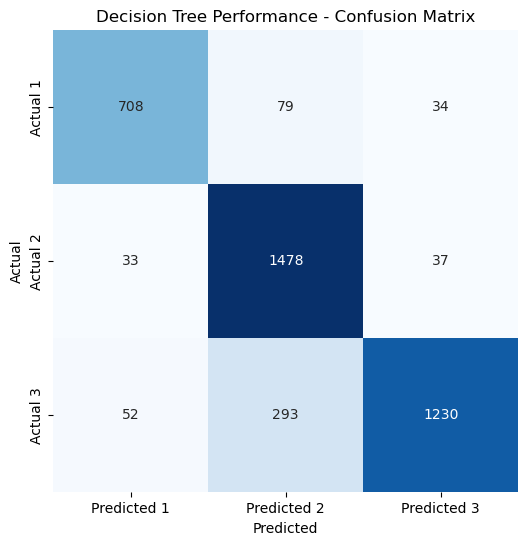


Decision Tree Performance - Classification Report

              precision    recall  f1-score   support

           1       0.89      0.86      0.88       821
           2       0.80      0.95      0.87      1548
           3       0.95      0.78      0.86      1575

    accuracy                           0.87      3944
   macro avg       0.88      0.87      0.87      3944
weighted avg       0.88      0.87      0.87      3944



In [ ]:
from evaluation import full_analysis_with_visuals

# Assuming an encoder was trained during preprocessing (if necessary)
encoder = None

full_analysis_with_visuals(
    model_name=model_name,
    model_func=model_func,
    results=results,
    best_method=best_method,
    X_test=X_test_M,
    y_test=y_test_M,
    encoder=encoder,
    title=f"{model_name} Performance",
    binary=False  # Set to True if binary classification
)


#### Random forest

In [ ]:
import evaluation
from supervised import random_forest_model

model_name = "Random Forest"
model_func = random_forest_model

results, best_method = evaluation.evaluate_model_with_sampling(
    model_func, model_name, X_train_M, y_train_M, encode=False
)
print(f"Best Sampling Method: {best_method}")
print(f"Results: {results}")





Evaluating Random Forest...
Applying SMOTE for oversampling...
Équilibrage effectué avec SMOTE (oversampling).
Running Random Forest grid search...
Random Forest (Oversampling): Best Params: {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 200}
Accuracy for Random Forest (Oversampling): 0.3994
Applying NearMiss for undersampling...
Équilibrage effectué avec NearMiss (undersampling).
Running Random Forest grid search...
Random Forest (Undersampling): Best Params: {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 200}
Accuracy for Random Forest (Undersampling): 0.8570
Applying SMOTETomek for combination...
Équilibrage effectué avec SMOTETomek (combination).
Running Random Forest grid search...
Random Forest (Combination): Best Params: {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 200}
Accuracy for Random Forest (Combination): 0.9223

Best Sampling Method for Random Forest: Combination with Accuracy: 0.9223
Best Sampling Method: Combination
Results: {'Oversam

In [ ]:
from evaluation import full_analysis_with_visuals

encoder = None

full_analysis_with_visuals(
    model_name=model_name,
    model_func=model_func,
    results=results,
    best_method=best_method,
    X_test=X_test_M,
    y_test=y_test_M,
    encoder=encoder,
    title=f"{model_name} Performance",
    binary=False
)

#### KNN

In [ ]:
import evaluation
from supervised import knn_model

model_name = "KNN"
model_func = knn_model

results, best_method = evaluation.evaluate_model_with_sampling(
    model_func, model_name, X_train_M, y_train_M, encode=False
)
print(f"Best Sampling Method: {best_method}")
print(f"Results: {results}")




Evaluating KNN...
Applying SMOTE for oversampling...
Data normalized using 'standard' method (NumPy array).
Équilibrage effectué avec SMOTE (oversampling).
Running KNN grid search...
KNN (Oversampling): Best Params: {'metric': 'manhattan', 'n_neighbors': 9, 'weights': 'distance'}
Accuracy for KNN (Oversampling): 0.4682
Applying NearMiss for undersampling...
Data normalized using 'standard' method (NumPy array).
Équilibrage effectué avec NearMiss (undersampling).
Running KNN grid search...
KNN (Undersampling): Best Params: {'metric': 'manhattan', 'n_neighbors': 9, 'weights': 'uniform'}
Accuracy for KNN (Undersampling): 0.3925
Applying SMOTETomek for combination...
Data normalized using 'standard' method (NumPy array).
Équilibrage effectué avec SMOTETomek (combination).
Running KNN grid search...
KNN (Combination): Best Params: {'metric': 'manhattan', 'n_neighbors': 9, 'weights': 'distance'}
Accuracy for KNN (Combination): 0.2081

Best Sampling Method for KNN: Oversampling with Accuracy


Training the best model (Oversampling) with parameters: {'metric': 'manhattan', 'n_neighbors': 9, 'weights': 'distance'}
Data is a numpy array. Skipping categorical encoding.
Data normalized using 'standard' method (NumPy array).
Running KNN grid search...


c:\Users\Rania\anaconda3\envs\basee\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Rania\anaconda3\envs\basee\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Rania\anaconda3\envs\basee\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


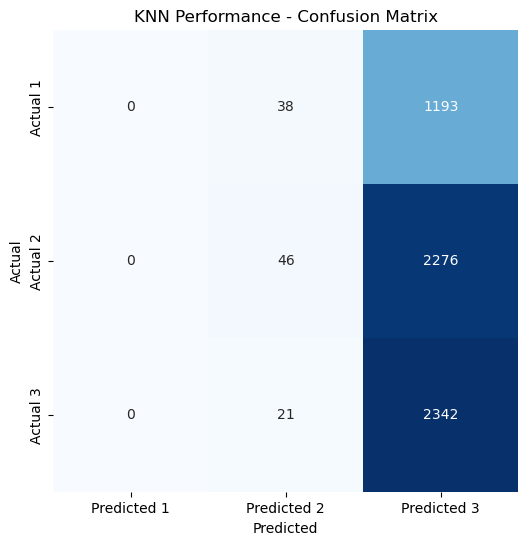


KNN Performance - Classification Report

              precision    recall  f1-score   support

           1       0.00      0.00      0.00      1231
           2       0.44      0.02      0.04      2322
           3       0.40      0.99      0.57      2363

    accuracy                           0.40      5916
   macro avg       0.28      0.34      0.20      5916
weighted avg       0.33      0.40      0.24      5916



In [ ]:
from evaluation import full_analysis_with_visuals

encoder = None

full_analysis_with_visuals(
    model_name=model_name,
    model_func=model_func,
    results=results,
    best_method=best_method,
    X_test=X_test_M,
    y_test=y_test_M,
    encoder=encoder,
    title=f"{model_name} Performance",
    binary=False
)


#### Xtra Trees

In [ ]:
import evaluation
from supervised import extra_trees_model

model_name = "Extra Trees"
model_func = extra_trees_model

results, best_method = evaluation.evaluate_model_with_sampling(
    model_func, model_name, X_train_M, y_train_M, encode=False
)
print(f"Best Sampling Method: {best_method}")
print(f"Results: {results}")




Evaluating Extra Trees...
Applying SMOTE for oversampling...
Équilibrage effectué avec SMOTE (oversampling).
Running Extra Trees grid search...
Extra Trees (Oversampling): Best Params: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
Accuracy for Extra Trees (Oversampling): 0.2136
Applying NearMiss for undersampling...
Équilibrage effectué avec NearMiss (undersampling).
Running Extra Trees grid search...
Extra Trees (Undersampling): Best Params: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Accuracy for Extra Trees (Undersampling): 0.9338
Applying SMOTETomek for combination...
Équilibrage effectué avec SMOTETomek (combination).
Running Extra Trees grid search...
Extra Trees (Combination): Best Params: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}
Accuracy for Extra Trees (Combination): 0.9946

Best Sampling Method for Extra Trees: Combination with Accuracy: 0.9946
Best Sampling Method: Combination
Results: {'Oversampling': {'Best P


Training the best model (Combination) with parameters: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}
Data is a numpy array. Skipping categorical encoding.
Running Extra Trees grid search...


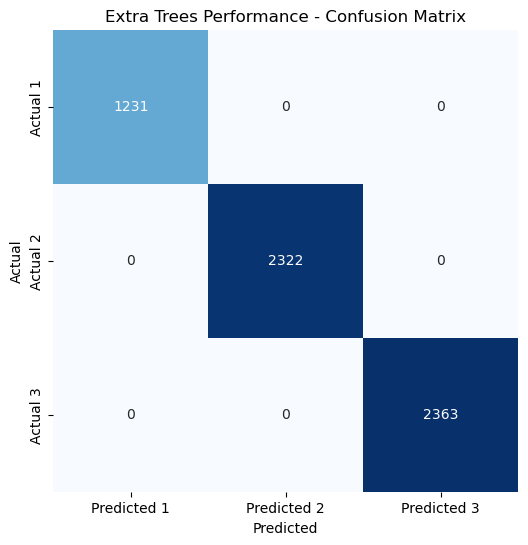


Extra Trees Performance - Classification Report

              precision    recall  f1-score   support

           1       1.00      1.00      1.00      1231
           2       1.00      1.00      1.00      2322
           3       1.00      1.00      1.00      2363

    accuracy                           1.00      5916
   macro avg       1.00      1.00      1.00      5916
weighted avg       1.00      1.00      1.00      5916



In [ ]:
from evaluation import full_analysis_with_visuals

encoder = None

full_analysis_with_visuals(
    model_name=model_name,
    model_func=model_func,
    results=results,
    best_method=best_method,
    X_test=X_test_M,
    y_test=y_test_M,
    encoder=encoder,
    title=f"{model_name} Performance",
    binary=False
)


#### AdaBoost

In [ ]:
import evaluation
from supervised import adaboost_model

model_name = "AdaBoost"
model_func = adaboost_model

results, best_method = evaluation.evaluate_model_with_sampling(
    model_func, model_name, X_train_M, y_train_M, encode=False
)
print(f"Best Sampling Method: {best_method}")
print(f"Results: {results}")





Evaluating AdaBoost...
Applying SMOTE for oversampling...
Équilibrage effectué avec SMOTE (oversampling).
Running AdaBoost grid search...
AdaBoost (Oversampling): Best Params: {'learning_rate': 0.2, 'n_estimators': 200}
Accuracy for AdaBoost (Oversampling): 0.2081
Applying NearMiss for undersampling...
Équilibrage effectué avec NearMiss (undersampling).
Running AdaBoost grid search...
AdaBoost (Undersampling): Best Params: {'learning_rate': 0.2, 'n_estimators': 200}
Accuracy for AdaBoost (Undersampling): 0.8278
Applying SMOTETomek for combination...
Équilibrage effectué avec SMOTETomek (combination).
Running AdaBoost grid search...
AdaBoost (Combination): Best Params: {'learning_rate': 0.2, 'n_estimators': 200}
Accuracy for AdaBoost (Combination): 0.8536

Best Sampling Method for AdaBoost: Combination with Accuracy: 0.8536
Best Sampling Method: Combination
Results: {'Oversampling': {'Best Params': {'learning_rate': 0.2, 'n_estimators': 200}, 'Accuracy': 0.20810086225635824}, 'Undersam


Training the best model (Combination) with parameters: {'learning_rate': 0.2, 'n_estimators': 200}
Data is a numpy array. Skipping categorical encoding.
Running AdaBoost grid search...


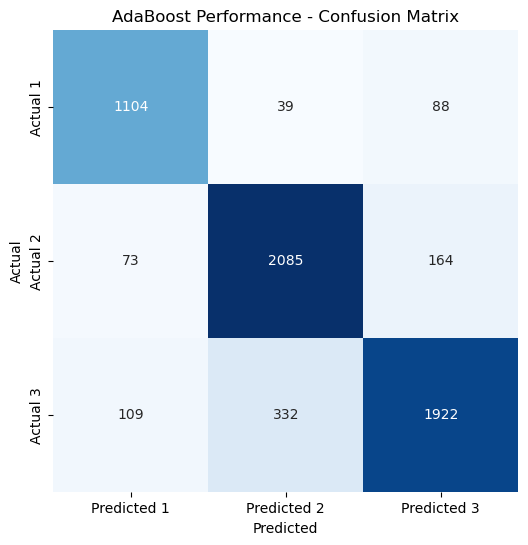


AdaBoost Performance - Classification Report

              precision    recall  f1-score   support

           1       0.86      0.90      0.88      1231
           2       0.85      0.90      0.87      2322
           3       0.88      0.81      0.85      2363

    accuracy                           0.86      5916
   macro avg       0.86      0.87      0.87      5916
weighted avg       0.86      0.86      0.86      5916



In [ ]:
from evaluation import full_analysis_with_visuals

encoder = None

full_analysis_with_visuals(
    model_name=model_name,
    model_func=model_func,
    results=results,
    best_method=best_method,
    X_test=X_test_M,
    y_test=y_test_M,
    encoder=encoder,
    title=f"{model_name} Performance",
    binary=False
)

#### Naiive Bayes

In [ ]:
import evaluation
from supervised import naive_bayes_model

model_name = "Naive Bayes"
model_func = naive_bayes_model

results, best_method = evaluation.evaluate_model_with_sampling(
    model_func, model_name, X_train_M, y_train_M, encode=False
)
print(f"Best Sampling Method: {best_method}")
print(f"Results: {results}")





Evaluating Naive Bayes...
Applying SMOTE for oversampling...
Équilibrage effectué avec SMOTE (oversampling).
Fitting Naive Bayes...
Naive Bayes (Oversampling): Best Params: None
Accuracy for Naive Bayes (Oversampling): 0.3994
Applying NearMiss for undersampling...
Équilibrage effectué avec NearMiss (undersampling).
Fitting Naive Bayes...
Naive Bayes (Undersampling): Best Params: None
Accuracy for Naive Bayes (Undersampling): 0.7579
Applying SMOTETomek for combination...
Équilibrage effectué avec SMOTETomek (combination).
Fitting Naive Bayes...
Naive Bayes (Combination): Best Params: None
Accuracy for Naive Bayes (Combination): 0.7576

Best Sampling Method for Naive Bayes: Undersampling with Accuracy: 0.7579
Best Sampling Method: Undersampling
Results: {'Oversampling': {'Best Params': None, 'Accuracy': 0.39939134845301066}, 'Undersampling': {'Best Params': None, 'Accuracy': 0.7579160930367365}, 'Combination': {'Best Params': None, 'Accuracy': 0.7576262589667415}}



Training the best model (Undersampling) with parameters: None
Data is a numpy array. Skipping categorical encoding.
Fitting Naive Bayes...


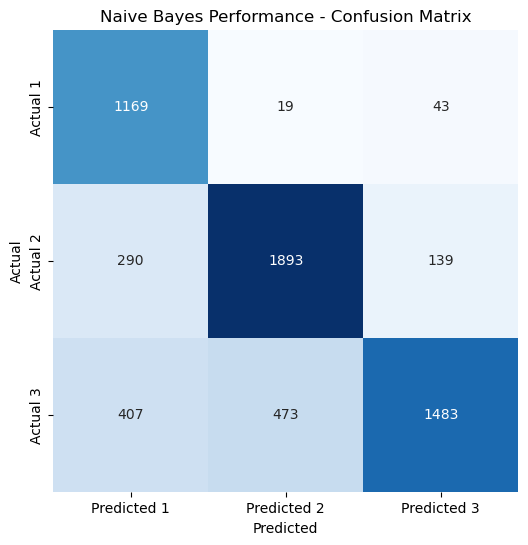


Naive Bayes Performance - Classification Report

              precision    recall  f1-score   support

           1       0.63      0.95      0.75      1231
           2       0.79      0.82      0.80      2322
           3       0.89      0.63      0.74      2363

    accuracy                           0.77      5916
   macro avg       0.77      0.80      0.77      5916
weighted avg       0.80      0.77      0.77      5916



In [ ]:
from evaluation import full_analysis_with_visuals

encoder = None

full_analysis_with_visuals(
    model_name=model_name,
    model_func=model_func,
    results=results,
    best_method=best_method,
    X_test=X_test_M,
    y_test=y_test_M,
    encoder=encoder,
    title=f"{model_name} Performance",
    binary=False
)

#### LDA

In [ ]:
import evaluation
from supervised import lda_model

model_name = "LDA"
model_func = lda_model

results, best_method = evaluation.evaluate_model_with_sampling(
    model_func, model_name, X_train_M, y_train_M, encode=False
)
print(f"Best Sampling Method: {best_method}")
print(f"Results: {results}")




Evaluating LDA...
Applying SMOTE for oversampling...
Équilibrage effectué avec SMOTE (oversampling).
Fitting LDA...
LDA (Oversampling): Best Params: None
Accuracy for LDA (Oversampling): 0.4027
Applying NearMiss for undersampling...
Équilibrage effectué avec NearMiss (undersampling).
Fitting LDA...
LDA (Undersampling): Best Params: None
Accuracy for LDA (Undersampling): 0.8673
Applying SMOTETomek for combination...
Équilibrage effectué avec SMOTETomek (combination).
Fitting LDA...
LDA (Combination): Best Params: None
Accuracy for LDA (Combination): 0.8825

Best Sampling Method for LDA: Combination with Accuracy: 0.8825
Best Sampling Method: Combination
Results: {'Oversampling': {'Best Params': None, 'Accuracy': 0.40272444025795234}, 'Undersampling': {'Best Params': None, 'Accuracy': 0.8673284544598218}, 'Combination': {'Best Params': None, 'Accuracy': 0.8824722846170567}}



Training the best model (Combination) with parameters: None
Data is a numpy array. Skipping categorical encoding.
Fitting LDA...


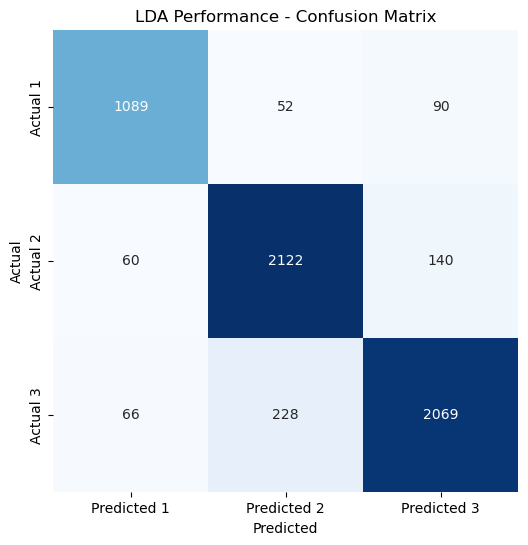


LDA Performance - Classification Report

              precision    recall  f1-score   support

           1       0.90      0.88      0.89      1231
           2       0.88      0.91      0.90      2322
           3       0.90      0.88      0.89      2363

    accuracy                           0.89      5916
   macro avg       0.89      0.89      0.89      5916
weighted avg       0.89      0.89      0.89      5916



In [ ]:
from evaluation import full_analysis_with_visuals

encoder = None

full_analysis_with_visuals(
    model_name=model_name,
    model_func=model_func,
    results=results,
    best_method=best_method,
    X_test=X_test_M,
    y_test=y_test_M,
    encoder=encoder,
    title=f"{model_name} Performance",
    binary=False
)


#### QDA

In [ ]:
import evaluation
from supervised import qda_model

model_name = "QDA"
model_func = qda_model

results, best_method = evaluation.evaluate_model_with_sampling(
    model_func, model_name, X_train_M, y_train_M, encode=False
)
print(f"Best Sampling Method: {best_method}")
print(f"Results: {results}")




Evaluating QDA...
Applying SMOTE for oversampling...
Équilibrage effectué avec SMOTE (oversampling).
Fitting QDA...


c:\Users\Rania\anaconda3\envs\basee\lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning:

Variables are collinear



QDA (Oversampling): Best Params: None
Accuracy for QDA (Oversampling): 0.3994
Applying NearMiss for undersampling...
Équilibrage effectué avec NearMiss (undersampling).
Fitting QDA...


c:\Users\Rania\anaconda3\envs\basee\lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning:

Variables are collinear



QDA (Undersampling): Best Params: None
Accuracy for QDA (Undersampling): 0.8030
Applying SMOTETomek for combination...
Équilibrage effectué avec SMOTETomek (combination).
Fitting QDA...


c:\Users\Rania\anaconda3\envs\basee\lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning:

Variables are collinear



QDA (Combination): Best Params: None
Accuracy for QDA (Combination): 0.8198

Best Sampling Method for QDA: Combination with Accuracy: 0.8198
Best Sampling Method: Combination
Results: {'Oversampling': {'Best Params': None, 'Accuracy': 0.39939134845301066}, 'Undersampling': {'Best Params': None, 'Accuracy': 0.8029852909209477}, 'Combination': {'Best Params': None, 'Accuracy': 0.8197956669806535}}



Training the best model (Combination) with parameters: None
Data is a numpy array. Skipping categorical encoding.
Fitting QDA...


c:\Users\Rania\anaconda3\envs\basee\lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning:

Variables are collinear



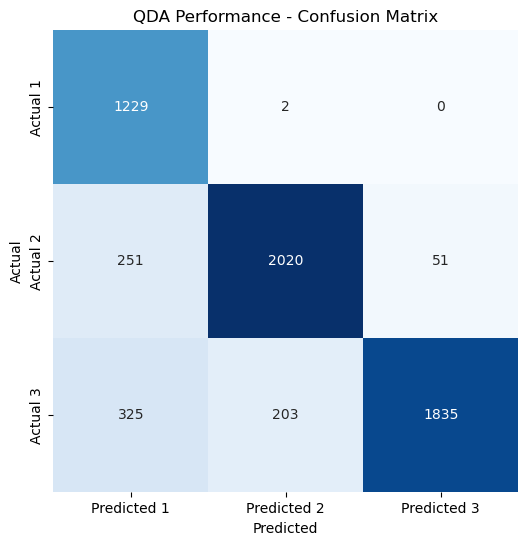


QDA Performance - Classification Report

              precision    recall  f1-score   support

           1       0.68      1.00      0.81      1231
           2       0.91      0.87      0.89      2322
           3       0.97      0.78      0.86      2363

    accuracy                           0.86      5916
   macro avg       0.85      0.88      0.85      5916
weighted avg       0.89      0.86      0.86      5916



In [ ]:
from evaluation import full_analysis_with_visuals

encoder = None

full_analysis_with_visuals(
    model_name=model_name,
    model_func=model_func,
    results=results,
    best_method=best_method,
    X_test=X_test_M,
    y_test=y_test_M,
    encoder=encoder,
    title=f"{model_name} Performance",
    binary=False
)
